### Package Imports

In [52]:
import os
import pandas as pd
import requests
from selenium import webdriver
from selenium.webdriver.firefox.options import Options
from bs4 import BeautifulSoup
import time
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from PyPDF2 import PdfReader
from io import BytesIO
import PyPDF2
import re
from tqdm import tqdm
import matplotlib.pyplot as plt
import squarify
import matplotlib.colors as mcolors
import numpy as np
from matplotlib.colors import rgb_to_hsv

### Pulling "First Click" Data

The code below produces an initial data frame of all admin policies.

Previously, I had tried iterating the same scrape function over each of the five initial links (Admin, OCHCO, CIO, CFO, CPO), but something between my code and the HTML syntax was causing the scrape to skip certain documents.

In order to debug and do some quality control, I'm doing all five scrapes separately and informing the code which policies it expects find, making it easier to discern when something is missing.

In [53]:
# Define the URL and type
url = "https://www.hud.gov/program_offices/administration/hudclips/handbooks/admh"
handbook_type = "admin"

# Set up Firefox options
options = Options()
options.headless = True  # Run in headless mode

# Initialize the WebDriver
driver = webdriver.Firefox(options=options)
driver.set_page_load_timeout(120)  # Increase the page load timeout to 120 seconds

try:
    # Load the webpage
    driver.get(url)

    # Wait for the page to load completely
    time.sleep(5)  # Adjust this delay as needed

    # Parse the page content with BeautifulSoup
    soup = BeautifulSoup(driver.page_source, 'html.parser')

finally:
    # Close the WebDriver
    driver.quit()

# Initialize the list to store hrefs
hrefs = []

# Find the <div> with id="areattl"
target_div = soup.find('div', id='areattl')

if target_div:
    # Find the next sibling after the target <div>
    target_section = target_div.find_next_sibling()

    # Iterate over all <li> tags in the section
    for li_tag in target_section.find_all('li'):
        # Find the <strong> tag and extract the handbook code
        strong_tag = li_tag.find('strong')
        if not strong_tag:
            continue
        handbook_code = strong_tag.text.strip()

        # Extract the handbook name and URL
        a_tag = li_tag.find('a', href=True)
        if a_tag:
            handbook_name = a_tag.text.strip()
            href = a_tag['href']
            full_url = href if href.startswith("http") else "https://www.hud.gov" + href

            hrefs.append({"handbook_code": handbook_code, "handbook_name": handbook_name, "handbook_notes": "", "url": full_url, "handbook_type": handbook_type})

# Add specific cases
specific_cases = [
    {"handbook_code": "3150.1", "handbook_name": "HUD Breach Notification Response Plan (HBNRP) Rev. 1.0", "handbook_notes": "", "url": "https://www.hud.gov/sites/dfiles/OCHCO/documents/3150.1admn.pdf", "handbook_type": handbook_type}
]

for case in specific_cases:
    if case not in hrefs:
        hrefs.append(case)

# Convert to DataFrame
admin_policy_hrefs = pd.DataFrame(hrefs)

# Check for missing policies
expected_policies = ["000.2", "1100.3", "1105.1", "1325.1", "1400.1", "1750.1", "2135.1", "2191.1", "2200.1", "2210.18", "2220.5", "2221.1", "2222.2", "2225.6", "2228.1", "2228.2", "2241.1", "2255.3", "2255.4", "2265.2", "2300.4", "3150.1", "3230.2", "791.1"]
found_policies = admin_policy_hrefs['handbook_code'].tolist()
missing_policies = [policy for policy in expected_policies if policy not in found_policies]

# Check for duplicates
duplicate_codes = admin_policy_hrefs[admin_policy_hrefs.duplicated(subset='handbook_code', keep=False)]

# Output results
print(f"Missing policies: {missing_policies}")
print(f"Number of duplicate codes: {duplicate_codes.shape[0]}")
print(f"Total number of codes: {admin_policy_hrefs.shape[0]}")

# Save to CSV
admin_policy_hrefs.to_csv('admin_policy_hrefs.csv', index=False)

admin_policy_hrefs

Missing policies: []
Number of duplicate codes: 0
Total number of codes: 24


,handbook_code,handbook_name,handbook_notes,url,handbook_type
0,000.2,HUD Directives System,,https://www.hud.gov/program_offices/administra...,admin
1,1100.3,Organization of the Department of Housing and ...,,https://www.hud.gov/program_offices/administra...,admin
2,1105.1,"Departmental Organization Policies, Standards ...",,https://www.hud.gov/program_offices/administra...,admin
3,1325.1,HUD Privacy Handbook Rev 1.0,,https://www.hud.gov/sites/dfiles/OCHCO/documen...,admin
4,1400.1,FOIA Proactive Disclosure Policy,,https://www.hud.gov/sites/dfiles/OCHCO/documen...,admin
5,1750.1,Information and Administrative Security Program,,https://www.hud.gov/program_offices/administra...,admin
6,2135.1,Forms Management,,https://www.hud.gov/program_offices/administra...,admin
7,2191.1,The Ideas Program Handbook,,https://www.hud.gov/program_offices/administra...,admin
8,2200.1,Administrative Services Policy,,https://www.hud.gov/program_offices/administra...,admin
9,2210.18,Cost Principles for For-Profit Organizations,,https://www.hud.gov/program_offices/administra...,admin


This seems to work. Moving on to CIO policies with the same method

As a reminder - since one of the limitations of this approach is that it looks at expected policies, it will not pick up newly added policies.

Doing this page by page does allow for me to handle exceptions, which I believe is where the initial error was. In this case, I have instructed it with how to handle variations in the HTML formatting so that it understands how to map values to the desired data frame without skipping over them.

In [54]:
# Define the URL and type
url = "https://www.hud.gov/program_offices/administration/hudclips/handbooks/cio"
handbook_type = "cio"

# Set up Firefox options
options = Options()
options.headless = True  # Run in headless mode

# Initialize the WebDriver
driver = webdriver.Firefox(options=options)
driver.set_page_load_timeout(120)  # Increase the page load timeout to 120 seconds

try:
    # Load the webpage
    driver.get(url)

    # Wait for the page to load completely
    time.sleep(5)  # Adjust this delay as needed

    # Parse the page content with BeautifulSoup
    soup = BeautifulSoup(driver.page_source, 'html.parser')

finally:
    # Close the WebDriver
    driver.quit()

# Initialize the list to store hrefs
hrefs = []

# Find the <div> with id="areattl"
target_div = soup.find('div', id='areattl')

if target_div:
    # Find the next sibling after the target <div>
    target_section = target_div.find_next_sibling()

    # Iterate over all <li> tags in the section
    for li_tag in target_section.find_all('li'):
        # Find the <strong> tag and extract the handbook code
        strong_tag = li_tag.find('strong')
        if not strong_tag:
            continue
        handbook_code = strong_tag.text.strip()

        # Extract the handbook name and URL
        a_tag = li_tag.find('a', href=True)
        if a_tag:
            handbook_name = a_tag.text.strip()
            href = a_tag['href']
            full_url = href if href.startswith("http") else "https://www.hud.gov" + href

            hrefs.append({"handbook_code": handbook_code, "handbook_name": handbook_name, "handbook_notes": "", "url": full_url, "handbook_type": handbook_type})

# Add specific cases
specific_cases = [
    {"handbook_code": "2400.24", "handbook_name": "ADP Security Program", "handbook_notes": "This Handbook has been replaced by handbook 2400.25", "url": "", "handbook_type": handbook_type},
    {"handbook_code": "3415.1", "handbook_name": "HUD Policy for Information Technology Governance", "handbook_notes": "", "url": "https://www.hud.gov/sites/dfiles/OCHCO/documents/34151CIOH.pdf", "handbook_type": handbook_type},
    {"handbook_code": "3417.1", "handbook_name": "Web Applications Policy", "handbook_notes": "", "url": "https://www.hud.gov/program_offices/administration/hudclips/handbooks/cio/3417.1", "handbook_type": handbook_type},
    {"handbook_code": "3420.1", "handbook_name": "HUD IT Capital Planning and Investment Control Process Guide", "handbook_notes": "The policy is superseded by the HUD IT Capital Planning and Investment Control Process Guide, published in 2020.", "url": "http://hudatwork.hud.gov/HUD/cio/doc/CPIC_guide101120", "handbook_type": handbook_type},
    {"handbook_code": "3425.1", "handbook_name": "HUD Policy for Information Technology Strategic Planning", "handbook_notes": "", "url": "https://www.hud.gov/program_offices/administration/hudclips/handbooks/cio/3425.1", "handbook_type": handbook_type}
]

for case in specific_cases:
    if case not in hrefs:
        hrefs.append(case)

# Convert to DataFrame
cio_policy_hrefs = pd.DataFrame(hrefs)

# Check for missing policies
expected_policies = ["2400.1", "2400.13", "2400.15", "2400.24", "2400.25", "2400.45", "3150.1", "3250.1", "3251.1", "3252.1", "3253.1", "3254.1", "3255.1", "3256.1", "3260.1", "3262.1", "3300.1", "3400.1", "3410.1", "3415.1", "3417.1", "3420.1", "3425.1", "3430.1", "3435.1", "3440.1", "3500.1"]
found_policies = cio_policy_hrefs['handbook_code'].tolist()
missing_policies = [policy for policy in expected_policies if policy not in found_policies]

# Check for duplicates
duplicate_codes = cio_policy_hrefs[cio_policy_hrefs.duplicated(subset='handbook_code', keep=False)]

# Output results
print(f"Missing policies: {missing_policies}")
print(f"Number of duplicate codes: {duplicate_codes.shape[0]}")
print(f"Total number of codes: {cio_policy_hrefs.shape[0]}")

# Save to CSV
cio_policy_hrefs.to_csv('cio_policy_hrefs.csv', index=False)

cio_policy_hrefs

Missing policies: []
Number of duplicate codes: 0
Total number of codes: 27


,handbook_code,handbook_name,handbook_notes,url,handbook_type
0,2400.1,Information Resources Management (IRM) Policies,,https://www.hud.gov/program_offices/administra...,cio
1,2400.13,Word Processing and Microcomputer Technology P...,,https://www.hud.gov/program_offices/administra...,cio
2,2400.15,HUD ADP Documentation Standards,,https://www.hud.gov/sites/documents/240015trnA...,cio
3,2400.25,Information Technology Security Policy,,https://www.hud.gov/program_offices/administra...,cio
4,2400.45,Vulnerability Disclosure Policy,,https://www.hud.gov/program_offices/administra...,cio
5,3150.1,Breach Notification Policy and Response Plan R...,,https://www.hud.gov/sites/dfiles/OCHCO/documen...,cio
6,3250.1,HUD Business Process Improvement,,https://www.hud.gov/program_offices/administra...,cio
7,3251.1,Secure Configuration Management Policy,,https://www.hud.gov/program_offices/administra...,cio
8,3252.1,Software Configuration Management Policy,,https://www.hud.gov/program_offices/administra...,cio
9,3253.1,Change Management Policy,,https://www.hud.gov/program_offices/administra...,cio


There do not appear to be duplicates above or instances of missed policies, so it seems safe to proceed.

Next is the initial CFO scrape

In [55]:
# Define the URL and type
url = "https://www.hud.gov/program_offices/administration/hudclips/handbooks/cfo"
handbook_type = "cfo"

# Set up Firefox options
options = Options()
options.headless = True  # Run in headless mode

# Initialize the WebDriver
driver = webdriver.Firefox(options=options)
driver.set_page_load_timeout(120)  # Increase the page load timeout to 120 seconds

try:
    # Load the webpage
    driver.get(url)

    # Wait for the page to load completely
    time.sleep(5)  # Adjust this delay as needed

    # Parse the page content with BeautifulSoup
    soup = BeautifulSoup(driver.page_source, 'html.parser')

finally:
    # Close the WebDriver
    driver.quit()

# Initialize the list to store hrefs
hrefs = []

# Find the <div> with id="areattl"
target_div = soup.find('div', id='areattl')

if target_div:
    # Find the next sibling after the target <div>
    target_section = target_div.find_next_sibling()

    # Iterate over all <li> tags in the section
    for li_tag in target_section.find_all('li'):
        # Find the <strong> tag and extract the handbook code
        strong_tag = li_tag.find('strong')
        if not strong_tag:
            continue
        handbook_code = strong_tag.text.strip()

        # Extract the handbook name and URL
        a_tag = li_tag.find('a', href=True)
        if a_tag:
            handbook_name = a_tag.text.strip()
            href = a_tag['href']
            full_url = href if href.startswith("http") else "https://www.hud.gov" + href

            hrefs.append({"handbook_code": handbook_code, "handbook_name": handbook_name, "handbook_notes": "", "url": full_url, "handbook_type": handbook_type})

# Add specific cases
specific_cases = [
    {"handbook_code": "1830.2", "handbook_name": "Administrative Control of Funds Policies", "handbook_notes": "Rev. 6 (HUD Use Only)", "url": "http://hudatwork.hud.gov/HUD/cfo/doc/Handbook%201830.2_%20REV6_March_20_2017", "handbook_type": handbook_type},
    {"handbook_code": "2010", "handbook_name": "Front End Risk Assessment Policy Handbook", "handbook_notes": "NEW Handbook", "url": "https://www.hud.gov/program_offices/administration/hudclips/handbooks/cfo/2010", "handbook_type": handbook_type},
    {"handbook_code": "2400.1", "handbook_name": "Single Audit Act Audit Resolution Policy", "handbook_notes": "", "url": "https://www.hud.gov/program_offices/administration/hudclips/handbooks/cfo/24001", "handbook_type": handbook_type}
]

for case in specific_cases:
    if case not in hrefs:
        hrefs.append(case)

# Convert to DataFrame
cfo_policy_hrefs = pd.DataFrame(hrefs)

# Check for missing policies
expected_policies = ["000.3", "14-002", "1830.2", "1830.6", "1841", "1900.25", "1900.29", "1900.40", "1911.1", "1980.1", "2000.06", "2010", "2018.1", "2019.1", "2019.2", "2021.1", "2022.1", "2210.17", "2300.1", "2400.1"]
found_policies = cfo_policy_hrefs['handbook_code'].tolist()
missing_policies = [policy for policy in expected_policies if policy not in found_policies]

# Check for duplicates
duplicate_codes = cfo_policy_hrefs[cfo_policy_hrefs.duplicated(subset='handbook_code', keep=False)]

# Output results
print(f"Missing policies: {missing_policies}")
print(f"Number of duplicate codes: {duplicate_codes.shape[0]}")
print(f"Total number of codes: {cfo_policy_hrefs.shape[0]}")
print(f"Duplicate policies: \n{duplicate_codes}")

cfo_policy_hrefs

Missing policies: []
Number of duplicate codes: 2
Total number of codes: 22
Duplicate policies: 
   handbook_code                             handbook_name  \
2         1830.2  Administrative Control of Funds Policies   
20        1830.2  Administrative Control of Funds Policies   

           handbook_notes                                                url  \
2                          http://hudatwork.hud.gov/HUD/cfo/doc/Handbook%...   
20  Rev. 6 (HUD Use Only)  http://hudatwork.hud.gov/HUD/cfo/doc/Handbook%...   

   handbook_type  
2            cfo  
20           cfo  


,handbook_code,handbook_name,handbook_notes,url,handbook_type
0,000.3,Budget Policy Handbook,,https://www.hud.gov/program_offices/administra...,cfo
1,14-002,Departmental Grant Accrual Policy,,https://www.hud.gov/sites/dfiles/OCHCO/documen...,cfo
2,1830.2,Administrative Control of Funds Policies,,http://hudatwork.hud.gov/HUD/cfo/doc/Handbook%...,cfo
3,1830.6,User Fees,,https://www.hud.gov/program_offices/administra...,cfo
4,1841,Departmental Policy on the Implementation of O...,,https://www.hud.gov/sites/dfiles/OCHCO/documen...,cfo
5,1900.25,Debt Collection,,https://www.hud.gov/program_offices/administra...,cfo
6,1900.29,Prompt Payment Policy,,https://www.hud.gov/program_offices/administra...,cfo
7,1900.40,Do Not Pay Policy,,https://www.hud.gov/sites/documents/190040CFOH...,cfo
8,1911.1,Handling and Protecting Cash and Other Negotia...,,https://www.hud.gov/program_offices/administra...,cfo
9,1980.1,Accounting Policies,,https://www.hud.gov/program_offices/administra...,cfo


In this instance, there were items that were scraped initially in one format, but then in a specified format later on, which can be noted by the appropriate handling of the handbook_notes section.

In this case, I will just hard-code which indices I want to drop

In [56]:
cfo_policy_hrefs.drop(cfo_policy_hrefs.index[[2,11]], inplace=True)
cfo_policy_hrefs

,handbook_code,handbook_name,handbook_notes,url,handbook_type
0,000.3,Budget Policy Handbook,,https://www.hud.gov/program_offices/administra...,cfo
1,14-002,Departmental Grant Accrual Policy,,https://www.hud.gov/sites/dfiles/OCHCO/documen...,cfo
3,1830.6,User Fees,,https://www.hud.gov/program_offices/administra...,cfo
4,1841,Departmental Policy on the Implementation of O...,,https://www.hud.gov/sites/dfiles/OCHCO/documen...,cfo
5,1900.25,Debt Collection,,https://www.hud.gov/program_offices/administra...,cfo
6,1900.29,Prompt Payment Policy,,https://www.hud.gov/program_offices/administra...,cfo
7,1900.40,Do Not Pay Policy,,https://www.hud.gov/sites/documents/190040CFOH...,cfo
8,1911.1,Handling and Protecting Cash and Other Negotia...,,https://www.hud.gov/program_offices/administra...,cfo
9,1980.1,Accounting Policies,,https://www.hud.gov/program_offices/administra...,cfo
10,2000.06,Audits Management System (AMS),,https://www.hud.gov/sites/documents/20006CFOH.pdf,cfo


In [57]:
# Sorting by handbook_code to eyeball any duplicates
cfo_policy_hrefs.sort_values('handbook_code')

,handbook_code,handbook_name,handbook_notes,url,handbook_type
0,000.3,Budget Policy Handbook,,https://www.hud.gov/program_offices/administra...,cfo
1,14-002,Departmental Grant Accrual Policy,,https://www.hud.gov/sites/dfiles/OCHCO/documen...,cfo
20,1830.2,Administrative Control of Funds Policies,Rev. 6 (HUD Use Only),http://hudatwork.hud.gov/HUD/cfo/doc/Handbook%...,cfo
3,1830.6,User Fees,,https://www.hud.gov/program_offices/administra...,cfo
4,1841,Departmental Policy on the Implementation of O...,,https://www.hud.gov/sites/dfiles/OCHCO/documen...,cfo
5,1900.25,Debt Collection,,https://www.hud.gov/program_offices/administra...,cfo
6,1900.29,Prompt Payment Policy,,https://www.hud.gov/program_offices/administra...,cfo
7,1900.40,Do Not Pay Policy,,https://www.hud.gov/sites/documents/190040CFOH...,cfo
8,1911.1,Handling and Protecting Cash and Other Negotia...,,https://www.hud.gov/program_offices/administra...,cfo
9,1980.1,Accounting Policies,,https://www.hud.gov/program_offices/administra...,cfo


In [58]:
# Find duplicate rows based on the 'handbook_code' column
duplicate_rows = cfo_policy_hrefs[cfo_policy_hrefs.duplicated(subset='url', keep=False)]

# Display the duplicate rows
duplicate_rows

,handbook_code,handbook_name,handbook_notes,url,handbook_type


#### And then save to CSV

In [59]:
# Save to CSV
cfo_policy_hrefs.to_csv('cfo_policy_hrefs.csv', index=False)

#### Next is the OCHCO scrape, which had a number of specific cases

In [60]:
# Define the URL and type
url = "https://www.hud.gov/program_offices/administration/hudclips/handbooks/ochco"
handbook_type = "ochco"

# Set up Firefox options
options = Options()
options.headless = True  # Run in headless mode

# Initialize the WebDriver
driver = webdriver.Firefox(options=options)
driver.set_page_load_timeout(120)  # Increase the page load timeout to 120 seconds

try:
    # Load the webpage
    driver.get(url)

    # Wait for the page to load completely
    time.sleep(5)  # Adjust this delay as needed

    # Parse the page content with BeautifulSoup
    soup = BeautifulSoup(driver.page_source, 'html.parser')

finally:
    # Close the WebDriver
    driver.quit()

# Initialize the list to store hrefs
hrefs = []

# Find the <div> with id="areattl"
target_div = soup.find('div', id='areattl')

if target_div:
    # Find the next sibling after the target <div>
    target_section = target_div.find_next_sibling()

    # Iterate over all <li> tags in the section
    for li_tag in target_section.find_all('li'):
        # Find the <strong> tag and extract the handbook code
        strong_tag = li_tag.find('strong')
        if not strong_tag:
            continue
        handbook_code = strong_tag.text.strip()

        # Extract the handbook name and URL
        a_tag = li_tag.find('a', href=True)
        if a_tag:
            handbook_name = a_tag.text.strip()
            href = a_tag['href']
            full_url = href if href.startswith("http") else "https://www.hud.gov" + href

            hrefs.append({"handbook_code": handbook_code, "handbook_name": handbook_name, "handbook_notes": "", "url": full_url, "handbook_type": handbook_type})

# Add specific cases
specific_cases = [
    {"handbook_code": "380.1", "handbook_name": "For Non-Bargaining And NFFE Bargaining Unit Employees", "handbook_notes": "PHASED RETIREMENT Program Policy & Procedures", "url": "https://www.hud.gov/sites/documents/3801CHOH.pdf", "handbook_type": handbook_type},
    {"handbook_code": "380.1", "handbook_name": "For AFGE Bargaining Unit Employees ONLY", "handbook_notes": "PHASED RETIREMENT Program Policy & Procedures", "url": "https://www.hud.gov/sites/dfiles/OCHCO/documents/3801ochco.pdf", "handbook_type": handbook_type},
    {"handbook_code": "745.1", "handbook_name": "Reorganizations, Realignments and Transfer of Function Policy", "handbook_notes": "HUD Only", "url": "http://hudatwork.hud.gov/HUD/chco/doc/reorganizationpolicy", "handbook_type": handbook_type},
    {"handbook_code": "750.1", "handbook_name": "Details, Interagency Agreement Assignments And Intergovernmental Personnel Act Assignments", "handbook_notes": "Non- BU and NFFE employees", "url": "https://www.hud.gov/sites/documents/750.1chch.pdf", "handbook_type": handbook_type},
    {"handbook_code": "750.1", "handbook_name": "Details, Interagency Agreement Assignments And Intergovernmental Personnel Act Assignments", "handbook_notes": "AFGE BU employees only", "url": "https://www.hud.gov/sites/documents/750.1afgechch.pdf", "handbook_type": handbook_type},
    {"handbook_code": "560.1", "handbook_name": "Pay, Leave and Other Benefits During Emergency/Disaster Situations", "handbook_notes": "", "url": "https://www.hud.gov/sites/documents/5601ADMH.pdf", "handbook_type": handbook_type},
    {"handbook_code": "602.1", "handbook_name": "Creditable Service for Annual Leave Accrual For Non-Federal Work and Military Service Experience", "handbook_notes": "", "url": "https://www.hud.gov/program_offices/administration/hudclips/handbooks/admh/602.1", "handbook_type": handbook_type},
    {"handbook_code": "610.01", "handbook_name": "Standard Operating Procedures and Guidance on Employee Volunteer Activities", "handbook_notes": "", "url": "https://www.hud.gov/sites/documents/61001CHCH.pdf", "handbook_type": handbook_type},
    {"handbook_code": "625.1", "handbook_name": "Flexiplace Policy Handbook", "handbook_notes": "", "url": "https://www.hud.gov/sites/dfiles/OCHCO/documents/FlexiplacePolicyHandbook625.1.pdf", "handbook_type": handbook_type},
    {"handbook_code": "650.1", "handbook_name": "HUD Hardship Reassignment Policy and Procedures", "handbook_notes": "", "url": "https://www.hud.gov/program_offices/administration/hudclips/handbooks/admh/650.1", "handbook_type": handbook_type},
    {"handbook_code": "655.1", "handbook_name": "Rotational Assignment Program Policy", "handbook_notes": "", "url": "https://www.hud.gov/sites/documents/admh-655.1.pdf", "handbook_type": handbook_type}
]

for case in specific_cases:
    if case not in hrefs:
        hrefs.append(case)

# Convert to DataFrame
ochco_policy_hrefs = pd.DataFrame(hrefs)

# Check for missing policies
expected_policies = [
    "2195.1", "2300.2", "2400.3", "330.1", "334.1", "335.1", "350.1", "380.1", "430.1", "432.1", "455.1",
    "460.1", "550.2", "560.1", "600.1", "600.3", "600.4", "602.1", "610.01", "625.1", "650.1", "655.1",
    "725.1", "730.1", "745.1", "750.1", "752.2", "771.2", "7855.1", "792.2", "793.1", "951.1"
]
found_policies = ochco_policy_hrefs['handbook_code'].tolist()
missing_policies = [policy for policy in expected_policies if policy not in found_policies]

# Check for duplicates
duplicate_codes = ochco_policy_hrefs[ochco_policy_hrefs.duplicated(subset='handbook_code', keep=False)]

# Output results
print(f"Missing policies: {missing_policies}")
print(f"Number of duplicate codes: {duplicate_codes.shape[0]}")
print(f"Total number of codes: {ochco_policy_hrefs.shape[0]}")
print(f"Duplicate policies: \n{duplicate_codes}")

ochco_policy_hrefs

Missing policies: []
Number of duplicate codes: 8
Total number of codes: 37
Duplicate policies: 
   handbook_code                                      handbook_name  \
7          380.1  For Non-Bargaining And NFFE Bargaining Unit Em...   
18         745.1  Reorganizations, Realignments and Transfer of ...   
19         750.1  Details, Interagency Agreement Assignments And...   
26         380.1  For Non-Bargaining And NFFE Bargaining Unit Em...   
27         380.1            For AFGE Bargaining Unit Employees ONLY   
28         745.1  Reorganizations, Realignments and Transfer of ...   
29         750.1  Details, Interagency Agreement Assignments And...   
30         750.1  Details, Interagency Agreement Assignments And...   

                                   handbook_notes  \
7                                                   
18                                                  
19                                                  
26  PHASED RETIREMENT Program Policy & Procedures  

,handbook_code,handbook_name,handbook_notes,url,handbook_type
0,2195.1,Incentive Awards,,https://www.hud.gov/sites/documents/21951CHCH.pdf,ochco
1,2300.2,Travel Handbook,,https://www.hud.gov/program_offices/administra...,ochco
2,2400.3,Reports Analysis and Clearance Process,,https://www.hud.gov/program_offices/administra...,ochco
3,330.1,Career Transition Assistance Program (CTAP) Po...,,https://www.hud.gov/sites/documents/330.1CHCH....,ochco
4,334.1,Personnel Clearinghouse Policy For Non-Bargain...,,https://www.hud.gov/sites/documents/334.1chch.pdf,ochco
5,335.1,Merit Staffing Policy,,https://www.hud.gov/program_offices/administra...,ochco
6,350.1,"Recruitment, Relocation, and Retention Incentives",,https://www.hud.gov/program_offices/administra...,ochco
7,380.1,For Non-Bargaining And NFFE Bargaining Unit Em...,,https://www.hud.gov/sites/documents/3801CHOH.pdf,ochco
8,430.1,Performance Management Plan,,https://www.hud.gov/sites/documents/4301CHCH.pdf,ochco
9,432.1,Performance Based Reduction in Grade and Remov...,,https://www.hud.gov/program_offices/administra...,ochco


#### Similar to above, there are a few duplicate rows I will have to drop, which I will hard-code and call using their index

In [61]:
# Find duplicate rows based on the 'handbook_code' column
duplicate_rows = ochco_policy_hrefs[ochco_policy_hrefs.duplicated(subset='handbook_code', keep=False)]

# Display the duplicate rows
duplicate_rows

,handbook_code,handbook_name,handbook_notes,url,handbook_type
7,380.1,For Non-Bargaining And NFFE Bargaining Unit Em...,,https://www.hud.gov/sites/documents/3801CHOH.pdf,ochco
18,745.1,"Reorganizations, Realignments and Transfer of ...",,http://hudatwork.hud.gov/HUD/chco/doc/reorgani...,ochco
19,750.1,"Details, Interagency Agreement Assignments And...",,https://www.hud.gov/sites/documents/750.1chch.pdf,ochco
26,380.1,For Non-Bargaining And NFFE Bargaining Unit Em...,PHASED RETIREMENT Program Policy & Procedures,https://www.hud.gov/sites/documents/3801CHOH.pdf,ochco
27,380.1,For AFGE Bargaining Unit Employees ONLY,PHASED RETIREMENT Program Policy & Procedures,https://www.hud.gov/sites/dfiles/OCHCO/documen...,ochco
28,745.1,"Reorganizations, Realignments and Transfer of ...",HUD Only,http://hudatwork.hud.gov/HUD/chco/doc/reorgani...,ochco
29,750.1,"Details, Interagency Agreement Assignments And...",Non- BU and NFFE employees,https://www.hud.gov/sites/documents/750.1chch.pdf,ochco
30,750.1,"Details, Interagency Agreement Assignments And...",AFGE BU employees only,https://www.hud.gov/sites/documents/750.1afgec...,ochco


In [62]:
ochco_policy_hrefs.drop(ochco_policy_hrefs.index[[7,18,19]], inplace=True)
ochco_policy_hrefs

,handbook_code,handbook_name,handbook_notes,url,handbook_type
0,2195.1,Incentive Awards,,https://www.hud.gov/sites/documents/21951CHCH.pdf,ochco
1,2300.2,Travel Handbook,,https://www.hud.gov/program_offices/administra...,ochco
2,2400.3,Reports Analysis and Clearance Process,,https://www.hud.gov/program_offices/administra...,ochco
3,330.1,Career Transition Assistance Program (CTAP) Po...,,https://www.hud.gov/sites/documents/330.1CHCH....,ochco
4,334.1,Personnel Clearinghouse Policy For Non-Bargain...,,https://www.hud.gov/sites/documents/334.1chch.pdf,ochco
5,335.1,Merit Staffing Policy,,https://www.hud.gov/program_offices/administra...,ochco
6,350.1,"Recruitment, Relocation, and Retention Incentives",,https://www.hud.gov/program_offices/administra...,ochco
8,430.1,Performance Management Plan,,https://www.hud.gov/sites/documents/4301CHCH.pdf,ochco
9,432.1,Performance Based Reduction in Grade and Remov...,,https://www.hud.gov/program_offices/administra...,ochco
10,455.1,"Departmental Supervisory, Management and Execu...",,https://www.hud.gov/sites/documents/455.1CHCH.pdf,ochco


In [63]:
# Sorting values by column handbook_code to eyeball any duplicates now that they've been removed
ochco_policy_hrefs.sort_values('handbook_code')

,handbook_code,handbook_name,handbook_notes,url,handbook_type
0,2195.1,Incentive Awards,,https://www.hud.gov/sites/documents/21951CHCH.pdf,ochco
1,2300.2,Travel Handbook,,https://www.hud.gov/program_offices/administra...,ochco
2,2400.3,Reports Analysis and Clearance Process,,https://www.hud.gov/program_offices/administra...,ochco
3,330.1,Career Transition Assistance Program (CTAP) Po...,,https://www.hud.gov/sites/documents/330.1CHCH....,ochco
4,334.1,Personnel Clearinghouse Policy For Non-Bargain...,,https://www.hud.gov/sites/documents/334.1chch.pdf,ochco
5,335.1,Merit Staffing Policy,,https://www.hud.gov/program_offices/administra...,ochco
6,350.1,"Recruitment, Relocation, and Retention Incentives",,https://www.hud.gov/program_offices/administra...,ochco
27,380.1,For AFGE Bargaining Unit Employees ONLY,PHASED RETIREMENT Program Policy & Procedures,https://www.hud.gov/sites/dfiles/OCHCO/documen...,ochco
26,380.1,For Non-Bargaining And NFFE Bargaining Unit Em...,PHASED RETIREMENT Program Policy & Procedures,https://www.hud.gov/sites/documents/3801CHOH.pdf,ochco
8,430.1,Performance Management Plan,,https://www.hud.gov/sites/documents/4301CHCH.pdf,ochco


In [64]:
# Find duplicate rows based on the 'url' column
duplicate_rows = ochco_policy_hrefs[ochco_policy_hrefs.duplicated(subset='url', keep=False)]

# Display the duplicate rows
duplicate_rows

,handbook_code,handbook_name,handbook_notes,url,handbook_type


In [65]:
# Save to CSV
ochco_policy_hrefs.to_csv('ochco_policy_hrefs.csv', index=False)

Last is the easiest scrape, which is the CPO handbook. Since there is only one policy after clicking this link, I've instructed the code with exactly how to handle it.

In [66]:
# Define the URL and type
url = "https://www.hud.gov/program_offices/administration/hudclips/handbooks/cpo"
handbook_type = "cpo"

# Set up Firefox options
options = Options()
options.headless = True  # Run in headless mode

# Initialize the WebDriver
driver = webdriver.Firefox(options=options)
driver.set_page_load_timeout(120)  # Increase the page load timeout to 120 seconds

try:
    # Load the webpage
    driver.get(url)

    # Wait for the page to load completely
    time.sleep(5)  # Adjust this delay as needed

    # Parse the page content with BeautifulSoup
    soup = BeautifulSoup(driver.page_source, 'html.parser')

finally:
    # Close the WebDriver
    driver.quit()

# Initialize the list to store hrefs
hrefs = []

# Find the <div> with id="areattl"
target_div = soup.find('div', id='areattl')

if target_div:
    # Find the next sibling after the target <div>
    target_section = target_div.find_next_sibling()

    # Iterate over all <li> tags in the section
    for li_tag in target_section.find_all('li'):
        # Find the <strong> tag and extract the handbook code
        strong_tag = li_tag.find('strong')
        if not strong_tag:
            continue
        handbook_code = strong_tag.text.strip()

        # Extract the handbook name and URL
        a_tag = li_tag.find('a', href=True)
        if a_tag:
            handbook_name = a_tag.text.strip()
            href = a_tag['href']
            full_url = href if href.startswith("http") else "https://www.hud.gov" + href

            hrefs.append({"handbook_code": handbook_code, "handbook_name": handbook_name, "handbook_notes": "", "url": full_url, "handbook_type": handbook_type})

# Add specific case for CPO
specific_cases = [
    {"handbook_code": "2210.3", "handbook_name": "HUD Procurement Handbook", "handbook_notes": "Revision 10, March 31, 2017 (Change 1, March 2019)", "url": "https://www.hud.gov/sites/dfiles/Main/documents/22103R10.pdf", "handbook_type": handbook_type}
]

for case in specific_cases:
    if case not in hrefs:
        hrefs.append(case)

# Convert to DataFrame
cpo_policy_hrefs = pd.DataFrame(hrefs)

# Check for missing policies
expected_policies = ["2210.3"]
found_policies = cpo_policy_hrefs['handbook_code'].tolist()
missing_policies = [policy for policy in expected_policies if policy not in found_policies]

# Check for duplicates
duplicate_codes = cpo_policy_hrefs[cpo_policy_hrefs.duplicated(subset='handbook_code', keep=False)]

# Output results
print(f"Missing policies: {missing_policies}")
print(f"Number of duplicate codes: {duplicate_codes.shape[0]}")
print(f"Total number of codes: {cpo_policy_hrefs.shape[0]}")
print(f"Duplicate policies: \n{duplicate_codes}")

# Save to CSV
cpo_policy_hrefs.to_csv('cpo_policy_hrefs.csv', index=False)

cpo_policy_hrefs

Missing policies: []
Number of duplicate codes: 0
Total number of codes: 1
Duplicate policies: 
Empty DataFrame
Columns: [handbook_code, handbook_name, handbook_notes, url, handbook_type]
Index: []


,handbook_code,handbook_name,handbook_notes,url,handbook_type
0,2210.3,HUD Procurement Handbook,"Revision 10, March 31, 2017 (Change 1, March 2...",https://www.hud.gov/sites/dfiles/Main/document...,cpo


Now we have these 5 separate data frames which we can stack into one.

In [67]:
# Combine the DataFrames into one
handbook_taxonomy = pd.concat([admin_policy_hrefs, cio_policy_hrefs, cfo_policy_hrefs, ochco_policy_hrefs, cpo_policy_hrefs], ignore_index=True)

# Output the combined DataFrame
print(f"Total number of codes in combined DataFrame: {handbook_taxonomy.shape[0]}")

# Save to CSV
handbook_taxonomy.to_csv('handbook_taxonomy.csv', index=False)

handbook_taxonomy

Total number of codes in combined DataFrame: 106


,handbook_code,handbook_name,handbook_notes,url,handbook_type
0,000.2,HUD Directives System,,https://www.hud.gov/program_offices/administra...,admin
1,1100.3,Organization of the Department of Housing and ...,,https://www.hud.gov/program_offices/administra...,admin
2,1105.1,"Departmental Organization Policies, Standards ...",,https://www.hud.gov/program_offices/administra...,admin
3,1325.1,HUD Privacy Handbook Rev 1.0,,https://www.hud.gov/sites/dfiles/OCHCO/documen...,admin
4,1400.1,FOIA Proactive Disclosure Policy,,https://www.hud.gov/sites/dfiles/OCHCO/documen...,admin
...,...,...,...,...,...
101,610.01,Standard Operating Procedures and Guidance on ...,,https://www.hud.gov/sites/documents/61001CHCH.pdf,ochco
102,625.1,Flexiplace Policy Handbook,,https://www.hud.gov/sites/dfiles/OCHCO/documen...,ochco
103,650.1,HUD Hardship Reassignment Policy and Procedures,,https://www.hud.gov/program_offices/administra...,ochco
104,655.1,Rotational Assignment Program Policy,,https://www.hud.gov/sites/documents/admh-655.1...,ochco


In [68]:
# Find duplicate rows based on the 'url' column
duplicate_rows = handbook_taxonomy[handbook_taxonomy.duplicated(subset='url', keep=False)]

# Display the duplicate rows
duplicate_rows

,handbook_code,handbook_name,handbook_notes,url,handbook_type


In [69]:
# Get the count of rows by handbook_type
handbook_type_counts = handbook_taxonomy['handbook_type'].value_counts()
handbook_type_counts

handbook_type
ochco    34
cio      27
admin    24
cfo      20
cpo       1
Name: count, dtype: int64

handbook_taxonomy is now a picture of the "first click" into each of the 5 handbooks

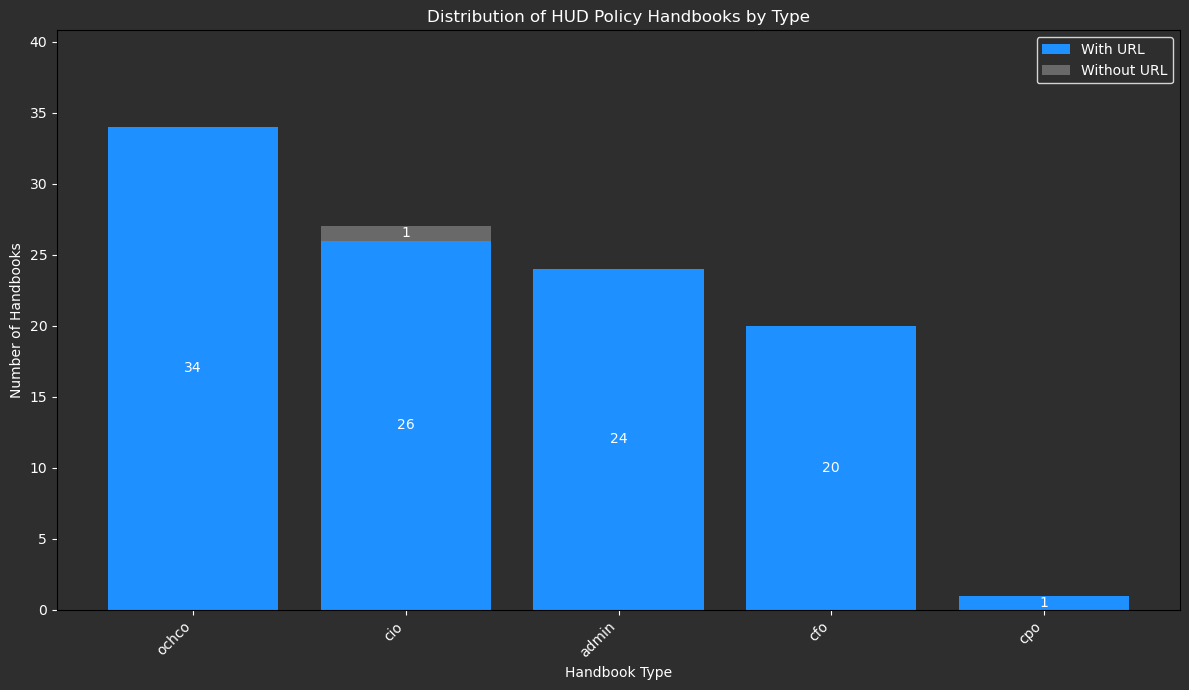

In [70]:
# Count the occurrences of each handbook_type
handbook_counts = handbook_taxonomy['handbook_type'].value_counts().sort_values(ascending=False)

# Count the occurrences with and without URL for each handbook_type
handbook_with_url = handbook_taxonomy[handbook_taxonomy['url'] != '']
handbook_without_url = handbook_taxonomy[handbook_taxonomy['url'] == '']

counts_with_url = handbook_with_url['handbook_type'].value_counts().reindex(handbook_counts.index, fill_value=0)
counts_without_url = handbook_without_url['handbook_type'].value_counts().reindex(handbook_counts.index, fill_value=0)

# Create the plot
fig, ax = plt.subplots(figsize=(12, 7), facecolor='#2E2E2E')
ax.set_facecolor('#2E2E2E')

# Plot the bars
bars_with_url = ax.bar(handbook_counts.index, counts_with_url, color='#1E90FF', label='With URL')
bars_without_url = ax.bar(handbook_counts.index, counts_without_url, bottom=counts_with_url, color='#696969', label='Without URL')

# Add labels and title
ax.set_xlabel('Handbook Type', color='white')
ax.set_ylabel('Number of Handbooks', color='white')
ax.set_title('Distribution of HUD Policy Handbooks by Type', color='white')
legend = ax.legend(facecolor='#2E2E2E', edgecolor='white')
for text in legend.get_texts():
    text.set_color("white")

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right', color='white')
ax.tick_params(colors='white')

# Adjust y-axis limit
ax.set_ylim([0, max(handbook_counts) * 1.2])

# Add data labels
for bar, label in zip(bars_with_url, handbook_counts.index):
    height = bar.get_height()
    if height > 0:
        ax.text(bar.get_x() + bar.get_width() / 2, height / 2, f'{int(height)}', ha='center', va='center', color='white', fontsize=10)

for bar, label in zip(bars_without_url, handbook_counts.index):
    height = bar.get_height()
    base_height = counts_with_url[label]
    if height > 0:
        ax.text(bar.get_x() + bar.get_width() / 2, base_height + height / 2, f'{int(height)}', ha='center', va='center', color='white', fontsize=10)

# Display the plot
plt.tight_layout()
plt.show()

# Second Click Scrape
## Straight to PDF

To prepare for the next set of scraping - going a the "second click" deeper - let's subset any values where the URL scraped upon first-click ends with PDF and handle these first, as they'll be simpler than anything that taxonomically has a landing page before getting to our final destination (i.e. the policies themselves)

In [71]:
# Subset for rows where the URL ends in .pdf or .PDF (case-insensitive) and remove any trailing spaces
handbook_taxonomy_pdfs = handbook_taxonomy[handbook_taxonomy['url'].str.lower().str.strip().str.endswith('.pdf')]

# Subset for rows where the URL does not end in .pdf (case-insensitive) and considering trailing spaces
handbook_taxonomy_landingpages = handbook_taxonomy[~handbook_taxonomy['url'].str.lower().str.strip().str.endswith('.pdf')]

# Print the shapes of the subsets to verify
print("handbook_taxonomy_pdfs shape:", handbook_taxonomy_pdfs.shape)
print("handbook_taxonomy_landingpages shape:", handbook_taxonomy_landingpages.shape)

handbook_taxonomy_pdfs shape: (39, 5)
handbook_taxonomy_landingpages shape: (67, 5)


In [72]:
# Save to CSV
handbook_taxonomy_pdfs.to_csv('handbook_taxonomy_pdfs.csv', index=False)
handbook_taxonomy_landingpages.to_csv('handbook_taxonomy_landingpages.csv', index=False)

In [73]:
# Function to check if URL is accessible and extract text from PDF
def check_url_and_extract_text(url):
    try:
        options = Options()
        options.headless = True
        driver = webdriver.Firefox(options=options)
        driver.set_page_load_timeout(120)  # Increase the page load timeout to 120 seconds

        try:
            # Load the webpage
            driver.get(url)

            # Wait for the page to load completely
            time.sleep(5)  # Adjust this delay as needed

            response = requests.get(url, timeout=10)
            response.raise_for_status()  # Raise an HTTPError for bad responses

            # Extract text from the PDF
            pdf = PdfReader(BytesIO(response.content))
            text = ""
            for page_num in range(len(pdf.pages)):
                text += pdf.pages[page_num].extract_text()

            driver.quit()
            return True, text

        except Exception as e:
            print(f"Failed to access or extract text from {url}: {e}")
            driver.quit()
            return False, ""
    except Exception as e:
        print(f"Failed to set up browser for {url}: {e}")
        return False, ""

# Function to check if a PDF is searchable
def is_searchable_pdf(text):
    common_words = ["the", "and", "a", "to", "of", "in", "that", "is", "for", "on"]
    word_count = len(text.split())
    common_word_count = sum(text.lower().count(word) for word in common_words)
    return word_count > 10 and common_word_count > 5

# List of keywords to search for
keywords = ['508', 'disab', 'accessib', 'assistive tech', 'rehab', 'ICT']

# Create a new DataFrame for the scraped results
SCRAPED_handbook_taxonomy_pdfs = handbook_taxonomy_pdfs.copy()

# Initialize the columns for keywords, url_test, and searchable
for keyword in keywords:
    SCRAPED_handbook_taxonomy_pdfs[keyword] = 0

SCRAPED_handbook_taxonomy_pdfs['url_test'] = False
SCRAPED_handbook_taxonomy_pdfs['searchable'] = False

# Iterate over each row to check URL and extract text
for index, row in SCRAPED_handbook_taxonomy_pdfs.iterrows():
    url = row['url']
    url_works, text = check_url_and_extract_text(url)
    SCRAPED_handbook_taxonomy_pdfs.at[index, 'url_test'] = url_works
    if url_works:
        # Check if the PDF is searchable
        is_searchable = is_searchable_pdf(text)
        SCRAPED_handbook_taxonomy_pdfs.at[index, 'searchable'] = is_searchable
        
        if is_searchable:
            # Count occurrences of each keyword in the text
            for keyword in keywords:
                keyword_count = text.lower().count(keyword)
                SCRAPED_handbook_taxonomy_pdfs.at[index, keyword] = keyword_count

# Save the updated DataFrame to CSV
#SCRAPED_handbook_taxonomy_pdfs.to_csv('SCRAPED_handbook_taxonomy_pdfs_with_keywords.csv', index=False)

SCRAPED_handbook_taxonomy_pdfs

Failed to access or extract text from https://www.hud.gov/sites/documents/330.1CHCH.pdf : 403 Client Error: Forbidden for url: https://www.hud.gov/sites/documents/330.1CHCH.pdf%20


,handbook_code,handbook_name,handbook_notes,url,handbook_type,508,disab,accessib,assistive tech,rehab,ICT,url_test,searchable
3,1325.1,HUD Privacy Handbook Rev 1.0,,https://www.hud.gov/sites/dfiles/OCHCO/documen...,admin,0,0,2,0,0,0,True,True
4,1400.1,FOIA Proactive Disclosure Policy,,https://www.hud.gov/sites/dfiles/OCHCO/documen...,admin,0,1,0,0,0,0,True,True
20,2300.4,Fleet Management,,https://www.hud.gov/sites/documents/23004ADMH.pdf,admin,0,1,1,0,0,0,True,True
21,3150.1,HUD Breach Notification Response Plan (HBNRP) ...,,https://www.hud.gov/sites/dfiles/OCHCO/documen...,admin,5,1,5,0,0,0,True,True
22,3230.2,Physical Security Handbook for HUD Regional an...,,https://www.hud.gov/sites/documents/32302ADMH.pdf,admin,0,34,4,0,0,0,True,True
26,2400.15,HUD ADP Documentation Standards,,https://www.hud.gov/sites/documents/240015trnA...,cio,0,0,0,0,0,0,True,True
29,3150.1,Breach Notification Policy and Response Plan R...,,https://www.hud.gov/sites/dfiles/OCHCO/documen...,cio,5,1,5,0,0,0,True,True
35,3255.1,Enterprise Architecture Policy,,https://www.hud.gov/sites/documents/32551CIOH.pdf,cio,1,4,4,1,3,0,True,True
37,3260.1,Enterprise Data Management (EDM) Policy,,https://www.hud.gov/sites/documents/32601CIOH.pdf,cio,0,0,1,0,0,0,True,True
39,3300.1,Total Information Quality Management,,https://www.hud.gov/sites/documents/33001CIOH.pdf,cio,0,0,5,0,0,0,True,True


In [74]:
# Ensuring we're getting the same amount of rows back that we began with
print("SCRAPED_handbook_taxonomy_pdfs shape:", SCRAPED_handbook_taxonomy_pdfs.shape)

SCRAPED_handbook_taxonomy_pdfs shape: (39, 13)


In [75]:
# Specifying the columns of interest
col_check = ['508', 'disab', 'accessib', 'assistive tech', 'rehab', 'ICT']

# Counting rows with at least one value greater than 0 in the specified columns
rows_with_values_greater_than_zero = SCRAPED_handbook_taxonomy_pdfs[col_check].gt(0).any(axis=1).sum()

print("Number of rows with at least one value greater than 0:", rows_with_values_greater_than_zero)

Number of rows with at least one value greater than 0: 20


## Landing Page Scrape

When I say "landing page," what I'm referring to is say you click here https://www.hud.gov/program_offices/administration/hudclips/handbooks/admh and then your next click - instead of leading you straight to a PDF like above - leads you to something like this -> https://www.hud.gov/program_offices/administration/hudclips/handbooks/admh/2225.6

These have a lot of varying HTML structure, so similar to the initial scrape, some of this is designed strictly to what the website looks like at this moment, handling exceptions / specific cases in clearly instructed ways

How do I make this scrape in batches of 10 headless?

In [76]:
# Function to extract PDF links and names from a landing page
def extract_pdfs_from_landing_page(url, handbook_code, handbook_name, handbook_notes, handbook_type):
    try:
        options = Options()
        options.headless = True
        driver = webdriver.Firefox(options=options)
        driver.set_page_load_timeout(120)

        try:
            driver.get(url)
            time.sleep(5)  # Adjust this delay as needed
            soup = BeautifulSoup(driver.page_source, 'html.parser')
            driver.quit()
        except Exception as e:
            print(f"Failed to access {url}: {e}")
            driver.quit()
            return []

        # Find all PDF links in the table
        pdf_links = []
        for row in soup.find_all('tr'):
            cells = row.find_all('td')
            if len(cells) == 2:
                pdf_name = cells[0].text.strip()
                pdf_link_tag = cells[1].find('a', href=True)
                if pdf_link_tag:
                    pdf_url = pdf_link_tag['href']
                    full_pdf_url = pdf_url if pdf_url.startswith("http") else "https://www.hud.gov" + pdf_url
                    pdf_links.append({
                        "handbook_code": handbook_code,
                        "handbook_name": handbook_name,
                        "handbook_notes": handbook_notes,
                        "url": url,
                        "handbook_type": handbook_type,
                        "pdf_name": pdf_name,
                        "pdf_url": full_pdf_url
                    })
        return pdf_links
    except Exception as e:
        print(f"Failed to extract PDFs from {url}: {e}")
        return []

# Create a new DataFrame for the extracted PDF links
extracted_pdf_links = []

# Iterate over each row in handbook_taxonomy_landingpages
for index, row in handbook_taxonomy_landingpages.iterrows():
    url = row['url']
    handbook_code = row['handbook_code']
    handbook_name = row['handbook_name']
    handbook_notes = row['handbook_notes']
    handbook_type = row['handbook_type']
    
    pdf_links = extract_pdfs_from_landing_page(url, handbook_code, handbook_name, handbook_notes, handbook_type)
    extracted_pdf_links.extend(pdf_links)

# Convert the list of extracted PDF links to a DataFrame
handbook_taxonomy_landingpages_with_pdfs = pd.DataFrame(extracted_pdf_links)

# Save the new DataFrame to CSV
handbook_taxonomy_landingpages_with_pdfs.to_csv('handbook_taxonomy_landingpages_with_pdfs.csv', index=False)

handbook_taxonomy_landingpages_with_pdfs

Failed to access : Message: Malformed URL: URL constructor:  is not a valid URL.
Stacktrace:
RemoteError@chrome://remote/content/shared/RemoteError.sys.mjs:8:8
WebDriverError@chrome://remote/content/shared/webdriver/Errors.sys.mjs:193:5
InvalidArgumentError@chrome://remote/content/shared/webdriver/Errors.sys.mjs:384:5
GeckoDriver.prototype.navigateTo@chrome://remote/content/marionette/driver.sys.mjs:837:11

Failed to access http://hudatwork.hud.gov/HUD/cio/doc/CPIC_guide101120: Message: Reached error page: about:neterror?e=dnsNotFound&u=http%3A//hudatwork.hud.gov/HUD/cio/doc/CPIC_guide101120&c=UTF-8&d=We%20can%E2%80%99t%20connect%20to%20the%20server%20at%20hudatwork.hud.gov.
Stacktrace:
RemoteError@chrome://remote/content/shared/RemoteError.sys.mjs:8:8
WebDriverError@chrome://remote/content/shared/webdriver/Errors.sys.mjs:193:5
UnknownError@chrome://remote/content/shared/webdriver/Errors.sys.mjs:832:5
checkReadyState@chrome://remote/content/marionette/navigate.sys.mjs:58:24
onNavigatio

,handbook_code,handbook_name,handbook_notes,url,handbook_type,pdf_name,pdf_url
0,000.2,HUD Directives System,,https://www.hud.gov/program_offices/administra...,admin,Transmittal (Rev 3),https://www.hud.gov/sites/documents/0002trnCHC...
1,000.2,HUD Directives System,,https://www.hud.gov/program_offices/administra...,admin,Complete Handbook,https://www.hud.gov/sites/documents/0002CHCH.pdf
2,000.2,HUD Directives System,,https://www.hud.gov/program_offices/administra...,admin,Table of Contents,https://www.hud.gov/sites/documents/0002tocCHC...
3,000.2,HUD Directives System,,https://www.hud.gov/program_offices/administra...,admin,SECTION A: THE HUD DIRECTIVES SYSTEM,https://www.hud.gov/sites/documents/0002c1CHCH...
4,000.2,HUD Directives System,,https://www.hud.gov/program_offices/administra...,admin,SECTION B: TYPES OF DIRECTIVES,https://www.hud.gov/sites/documents/0002c2CHCH...
...,...,...,...,...,...,...,...
585,602.1,Creditable Service for Annual Leave Accrual Fo...,,https://www.hud.gov/program_offices/administra...,ochco,Attachment: Form SF 144A,http://www.opm.gov/forms/pdf_fill/sf144a.pdf
586,650.1,HUD Hardship Reassignment Policy and Procedures,,https://www.hud.gov/program_offices/administra...,ochco,Cover,https://www.hud.gov/sites/documents/6501cvrCHC...
587,650.1,HUD Hardship Reassignment Policy and Procedures,,https://www.hud.gov/program_offices/administra...,ochco,Table of Contents,https://www.hud.gov/sites/documents/6501tocCHC...
588,650.1,HUD Hardship Reassignment Policy and Procedures,,https://www.hud.gov/program_offices/administra...,ochco,Handbook,https://www.hud.gov/sites/documents/6501CHCH.pdf


One url had instances of PDF, XLS and DOC files, so I want to make sure it scraped correctly.

In [168]:
# Define the specific URL
specific_url = "https://www.hud.gov/program_offices/administration/hudclips/handbooks/cfo/2010"

# Filter the DataFrame for rows where the url column matches the specific URL
filtered_rows = handbook_taxonomy_landingpages_with_pdfs[handbook_taxonomy_landingpages_with_pdfs['url'] == specific_url]

# Display the filtered rows
# Save the filtered rows to a CSV file
filtered_rows.to_csv('filtered_handbook_entries.csv', index=False)
filtered_rows

,handbook_code,handbook_name,handbook_notes,url,handbook_type,pdf_name,pdf_url
452,2010.0,Front End Risk Assessment Policy Handbook,NEW Handbook,https://www.hud.gov/program_offices/administra...,cfo,Full Handbook,https://www.hud.gov/sites/dfiles/OCHCO/documen...
453,2010.0,Front End Risk Assessment Policy Handbook,NEW Handbook,https://www.hud.gov/program_offices/administra...,cfo,Attachment A - FERA Commencement Form,https://www.hud.gov/sites/dfiles/OCHCO/documen...
454,2010.0,Front End Risk Assessment Policy Handbook,NEW Handbook,https://www.hud.gov/program_offices/administra...,cfo,Attachment B - Program Description Form,https://www.hud.gov/sites/dfiles/OCHCO/documen...
455,2010.0,Front End Risk Assessment Policy Handbook,NEW Handbook,https://www.hud.gov/program_offices/administra...,cfo,Attachment C - Risk Indicators and Ranking Guide,https://www.hud.gov/sites/dfiles/OCHCO/documen...
456,2010.0,Front End Risk Assessment Policy Handbook,NEW Handbook,https://www.hud.gov/program_offices/administra...,cfo,Attachment D - Risk Register and Mitigation St...,https://www.hud.gov/sites/dfiles/OCHCO/documen...
457,2010.0,Front End Risk Assessment Policy Handbook,NEW Handbook,https://www.hud.gov/program_offices/administra...,cfo,Attachment E - Mitigation Milestones and Activ...,https://www.hud.gov/sites/dfiles/OCHCO/documen...
458,2010.0,Front End Risk Assessment Policy Handbook,NEW Handbook,https://www.hud.gov/program_offices/administra...,cfo,Attachment F - FERA Review and Approval Form,https://www.hud.gov/sites/dfiles/OCHCO/documen...


I went back and verified the links that were flagged as "failed to access." These are indeed broken links on the website itself and not a failure of the script. I will pull these out and identify them separately.

In [128]:
# Filter rows where the URL contains "hudatwork"
contains_hudatwork = handbook_taxonomy_landingpages[
    handbook_taxonomy_landingpages['url'].str.contains("hudatwork", na=False)
]

# Display the filtered DataFrame
contains_hudatwork

,handbook_code,handbook_name,handbook_notes,url,handbook_type
49,3420.1,HUD IT Capital Planning and Investment Control...,The policy is superseded by the HUD IT Capital...,http://hudatwork.hud.gov/HUD/cio/doc/CPIC_guid...,cio
69,1830.2,Administrative Control of Funds Policies,Rev. 6 (HUD Use Only),http://hudatwork.hud.gov/HUD/cfo/doc/Handbook%...,cfo
96,745.1,"Reorganizations, Realignments and Transfer of ...",HUD Only,http://hudatwork.hud.gov/HUD/chco/doc/reorgani...,ochco


This means we can update our graph from before with a little more dimension

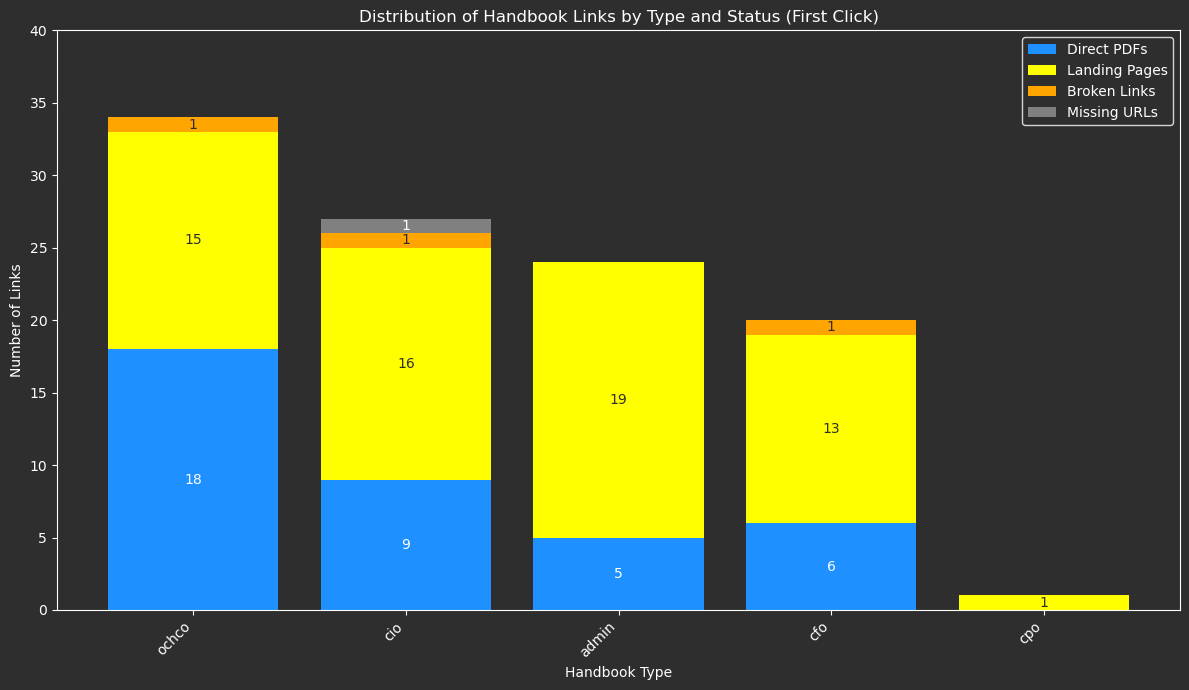

In [266]:
# Prepare counts
handbook_counts = handbook_taxonomy['handbook_type'].value_counts()

# Define each category
missing_urls = handbook_taxonomy[handbook_taxonomy['url'].isna() | (handbook_taxonomy['url'] == '')]['handbook_type'].value_counts().reindex(handbook_counts.index, fill_value=0)
broken_links = handbook_taxonomy[handbook_taxonomy['url'].str.contains("hudatwork", na=False)]['handbook_type'].value_counts().reindex(handbook_counts.index, fill_value=0)
direct_pdfs = handbook_taxonomy[handbook_taxonomy['url'].str.lower().str.strip().str.endswith('.pdf')]['handbook_type'].value_counts().reindex(handbook_counts.index, fill_value=0)
landing_pages = handbook_counts - (missing_urls + broken_links + direct_pdfs)

# Special case adjustment for 'cpo' to be considered as Landing Page instead of Direct PDF
if 'cpo' in direct_pdfs.index:
    cpo_count = direct_pdfs['cpo']
    direct_pdfs['cpo'] = 0  # Set Direct PDF count for 'cpo' to 0
    landing_pages['cpo'] += cpo_count  # Add the count to Landing Pages

# Ensure no negative counts in case of any overlap or calculation issues
landing_pages[landing_pages < 0] = 0

# Create the plot
fig, ax = plt.subplots(figsize=(12, 7), facecolor='#2E2E2E')
ax.set_facecolor('#2E2E2E')

# Plot bars in the new order
bars_pdfs = ax.bar(handbook_counts.index, direct_pdfs, color='#1E90FF', label='Direct PDFs')
bars_landing = ax.bar(handbook_counts.index, landing_pages, bottom=direct_pdfs, color='yellow', label='Landing Pages')
bars_broken = ax.bar(handbook_counts.index, broken_links, bottom=direct_pdfs + landing_pages, color='orange', label='Broken Links')
bars_missing = ax.bar(handbook_counts.index, missing_urls, bottom=direct_pdfs + landing_pages + broken_links, color='gray', label='Missing URLs')

# Add labels and title
ax.set_xlabel('Handbook Type', color='white')
ax.set_ylabel('Number of Links', color='white')
ax.set_title('Distribution of Handbook Links by Type and Status (First Click)', color='white')
legend = ax.legend(facecolor='#2E2E2E', edgecolor='white')
for text in legend.get_texts():
    text.set_color("white")

# Rotate x-axis labels
plt.xticks(rotation=45, ha='right', color='white')
ax.tick_params(colors='white')

# Set Y-axis limit
ax.set_ylim(0, 40)

# Function to add data labels with specific colors for visibility
def add_labels(bars, text_color='white'):
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            ax.text(bar.get_x() + bar.get_width() / 2, bar.get_y() + height / 2, f'{int(height)}', ha='center', va='center', color=text_color, fontsize=10)

# Adding labels. Remember to adjust text colors if needed against the yellow and orange bars for better visibility.
add_labels(bars_pdfs)
add_labels(bars_landing, text_color='#2E2E2E') # Dark background color for visibility against yellow
add_labels(bars_broken, text_color='#2E2E2E') # Dark background color for visibility against orange
add_labels(bars_missing)

# Save the plot as a JPG file
plt.savefig('first_click.jpg', format='jpg', dpi=300)

# Display the plot
plt.tight_layout()
plt.show()

Next, in order to QA and verify this lengthy scrape did what it was meant to do and hit all policies, I quickly put together my own spreadsheet of the number of expected PDFs per page called expected_pdfs_df. Since there were less than 80 first-click links scraped that had landing pages, it was easy to click each link, Command + F for "pdf" and then verify the number I was seeing for each.

Usually I had to just -1 since each page since there's a link with the term PDF at the bottom of each page, but this also helped me take inventory of any strange formatting or cases I would have to account for in the scrape. I flagged these using the different_formatting and broken_link columns you'll see below.

What the next code block does is take this raw file I made myself and compare the excpected_pdf_num - from my sheet - to the actual scraped_pdf_num, which is the count of new rows that all have the same url value.

Then it provides a True or False depending on if the values match, under the match column

In [146]:
# Load the expected PDFs CSV file
expected_pdfs_df = pd.read_csv('expected_pdfs_HUD - Sheet1.csv')

# Count the number of corresponding rows in handbook_taxonomy_landingpages_with_pdfs for each URL
url_counts = handbook_taxonomy_landingpages_with_pdfs['url'].value_counts().reset_index()
url_counts.columns = ['url', 'scraped_pdf_num']

# Merge the counts with the expected_pdfs_df
landingpage_scrape_qa = pd.merge(expected_pdfs_df, url_counts, on='url', how='left')

# Create a match column to indicate if the values match
landingpage_scrape_qa['match'] = landingpage_scrape_qa['expected_pdf_num'] == landingpage_scrape_qa['scraped_pdf_num']

# Select only the required columns
landingpage_scrape_qa = landingpage_scrape_qa[['url', 'expected_pdf_num', 'scraped_pdf_num', 'match', 'different_formatting', 'broken_link']]

# Save the resulting DataFrame to CSV
landingpage_scrape_qa.to_csv('landingpage_scrape_qa.csv', index=False)

landingpage_scrape_qa

,url,expected_pdf_num,scraped_pdf_num,match,different_formatting,broken_link
0,https://www.hud.gov/program_offices/administra...,11.0,11.0,True,NaN,NaN
1,https://www.hud.gov/program_offices/administra...,23.0,23.0,True,NaN,NaN
2,https://www.hud.gov/program_offices/administra...,16.0,16.0,True,1.0,NaN
3,https://www.hud.gov/program_offices/administra...,12.0,12.0,True,NaN,NaN
4,https://www.hud.gov/program_offices/administra...,12.0,12.0,True,NaN,NaN
...,...,...,...,...,...,...
62,https://www.hud.gov/program_offices/administra...,13.0,13.0,True,NaN,NaN
63,https://www.hud.gov/program_offices/administra...,5.0,5.0,True,NaN,NaN
64,http://hudatwork.hud.gov/HUD/chco/doc/reorgani...,NaN,NaN,False,NaN,1.0
65,https://www.hud.gov/program_offices/administra...,10.0,10.0,True,NaN,NaN


In order to see which links didn't scrape properly, I subset where match == False

In [147]:
# Subset of rows where match is FALSE
mismatch_subset = landingpage_scrape_qa[landingpage_scrape_qa['match'] == False]

mismatch_subset.to_csv('mismatch_subset.csv', index=False)

# Display the subset
mismatch_subset

,url,expected_pdf_num,scraped_pdf_num,match,different_formatting,broken_link
11,https://www.hud.gov/program_offices/administra...,55.0,49.0,False,1.0,NaN
13,https://www.archives.gov/records-mgmt/grs.html,NaN,NaN,False,1.0,NaN
33,NaN,0.0,NaN,False,NaN,NaN
35,http://hudatwork.hud.gov/HUD/cio/doc/CPIC_guid...,NaN,NaN,False,1.0,1.0
42,https://www.hud.gov/program_offices/administra...,34.0,29.0,False,1.0,NaN
49,http://hudatwork.hud.gov/HUD/cfo/doc/Handbook%...,NaN,NaN,False,1.0,1.0
50,https://www.hud.gov/program_offices/administra...,1.0,7.0,False,1.0,NaN
61,https://www.hud.gov/program_offices/administra...,24.0,NaN,False,1.0,NaN
64,http://hudatwork.hud.gov/HUD/chco/doc/reorgani...,NaN,NaN,False,NaN,1.0


## Handling Exceptions

Going through these cases one by one after downloading this small subset to a CSV, I then figure out how to rewrite the scrape to handle the variations I'm seeing

In three instances identified as meaningful after checking mismatch_subset, I instructed the code how to handle these variations

Then, I had it rescrape it and save it as its own data frame. Each of the exceptions encountered will roughly follow this process.

The first exception follows an irregular HTML structure, with subsections within the table-like component at https://www.hud.gov/program_offices/administration/hudclips/handbooks/admh/2225.6
Other issues to troubleshoot for are how 7 links are under one row or how a few rows marked RESERVED do not have corresponding PDFs, but we might want to keep stock of the website structure still

In [148]:
# Load the existing DataFrame
handbook_taxonomy_landingpages_with_pdfs = pd.read_csv('handbook_taxonomy_landingpages_with_pdfs.csv')

# Function to scrape PDF links
def scrape_pdfs(url, handbook_code, handbook_name, handbook_notes, handbook_type):
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')
    table = soup.find('table', {'border': '1'})
    rows = table.find_all('tr')
    pdf_rows = []
    for row in rows:
        cols = row.find_all('td')
        if len(cols) == 2:
            pdf_name = cols[0].get_text(strip=True)
            pdf_url_tag = cols[1].find('a')
            pdf_url = pdf_url_tag['href'] if pdf_url_tag else ""
            pdf_rows.append({
                "handbook_code": handbook_code,
                "handbook_name": handbook_name,
                "handbook_notes": handbook_notes,
                "url": url,
                "handbook_type": handbook_type,
                "pdf_name": pdf_name,
                "pdf_url": "https://www.hud.gov" + pdf_url if pdf_url else ""
            })
    return pdf_rows

# Exception 1 details
url_1 = "https://www.hud.gov/program_offices/administration/hudclips/handbooks/admh/2225.6"
handbook_code_1 = handbook_taxonomy_landingpages_with_pdfs.loc[handbook_taxonomy_landingpages_with_pdfs['url'] == url_1, 'handbook_code'].values[0]
handbook_name_1 = handbook_taxonomy_landingpages_with_pdfs.loc[handbook_taxonomy_landingpages_with_pdfs['url'] == url_1, 'handbook_name'].values[0]
handbook_notes_1 = handbook_taxonomy_landingpages_with_pdfs.loc[handbook_taxonomy_landingpages_with_pdfs['url'] == url_1, 'handbook_notes'].values[0]
handbook_type_1 = handbook_taxonomy_landingpages_with_pdfs.loc[handbook_taxonomy_landingpages_with_pdfs['url'] == url_1, 'handbook_type'].values[0]

reserved_sections_1 = [
    "SCHEDULE 26: RESERVED",
    "SCHEDULE 28: RESERVED",
    "SCHEDULE 38 - 48: RESERVED",
    "SCHEDULE 52 - 53: RESERVED",
    "SCHEDULE 57 - 59: RESERVED"
]
special_cases_1 = [
    {"pdf_name": "SCHEDULE 3: Administrative Records (1)", "pdf_url": "/sites/documents/22256x3admh-1.pdf"},
    {"pdf_name": "SCHEDULE 3: Administrative Records (2)", "pdf_url": "/sites/documents/22256x3admh-2.pdf"},
    {"pdf_name": "SCHEDULE 3: Administrative Records (3)", "pdf_url": "/sites/documents/22256x3admh-3.pdf"},
    {"pdf_name": "SCHEDULE 3: Administrative Records (4)", "pdf_url": "/sites/documents/22256x3admh-4.pdf"},
    {"pdf_name": "SCHEDULE 3: Administrative Records (5)", "pdf_url": "/sites/documents/22256x3admh-5.pdf"},
    {"pdf_name": "SCHEDULE 3: Administrative Records (6)", "pdf_url": "/sites/documents/22256x3admh-6.pdf"},
    {"pdf_name": "SCHEDULE 3: Administrative Records (7)", "pdf_url": "/sites/documents/22256x3admh-7.pdf"}
]

# Create rows for RESERVED sections
reserved_rows_1 = []
for section in reserved_sections_1:
    reserved_rows_1.append({
        "handbook_code": handbook_code_1,
        "handbook_name": handbook_name_1,
        "handbook_notes": handbook_notes_1,
        "url": url_1,
        "handbook_type": handbook_type_1,
        "pdf_name": section,
        "pdf_url": ""
    })

# Scrape remaining PDFs
remaining_pdfs_1 = scrape_pdfs(url_1, handbook_code_1, handbook_name_1, handbook_notes_1, handbook_type_1)

# Combine all rows into a single DataFrame
exception_1_df = pd.DataFrame(reserved_rows_1 + remaining_pdfs_1).drop_duplicates()

# Add special cases separately to avoid duplicates
for case in special_cases_1:
    if not ((exception_1_df['pdf_name'] == case["pdf_name"]) & (exception_1_df['pdf_url'] == case["pdf_url"])).any():
        exception_1_df = pd.concat([exception_1_df, pd.DataFrame([case])], ignore_index=True)

#exception_1_df.to_csv('exception_1_df.csv', index=False)

exception_1_df

,handbook_code,handbook_name,handbook_notes,url,handbook_type,pdf_name,pdf_url
0,2225.6,HUD Records Disposition Schedules,NaN,https://www.hud.gov/program_offices/administra...,admin,SCHEDULE 26: RESERVED,
1,2225.6,HUD Records Disposition Schedules,NaN,https://www.hud.gov/program_offices/administra...,admin,SCHEDULE 28: RESERVED,
2,2225.6,HUD Records Disposition Schedules,NaN,https://www.hud.gov/program_offices/administra...,admin,SCHEDULE 38 - 48: RESERVED,
3,2225.6,HUD Records Disposition Schedules,NaN,https://www.hud.gov/program_offices/administra...,admin,SCHEDULE 52 - 53: RESERVED,
4,2225.6,HUD Records Disposition Schedules,NaN,https://www.hud.gov/program_offices/administra...,admin,SCHEDULE 57 - 59: RESERVED,
...,...,...,...,...,...,...,...
62,NaN,NaN,NaN,NaN,NaN,SCHEDULE 3: Administrative Records (3),/sites/documents/22256x3admh-3.pdf
63,NaN,NaN,NaN,NaN,NaN,SCHEDULE 3: Administrative Records (4),/sites/documents/22256x3admh-4.pdf
64,NaN,NaN,NaN,NaN,NaN,SCHEDULE 3: Administrative Records (5),/sites/documents/22256x3admh-5.pdf
65,NaN,NaN,NaN,NaN,NaN,SCHEDULE 3: Administrative Records (6),/sites/documents/22256x3admh-6.pdf


The second instance had the usual table structure, but some rows had PDF as a regular text instead of hyperlinking to a document

In [149]:
# Load the existing DataFrame
handbook_taxonomy_landingpages_with_pdfs = pd.read_csv('handbook_taxonomy_landingpages_with_pdfs.csv')

# Function to scrape PDF links
def scrape_pdfs(url, handbook_code, handbook_name, handbook_notes, handbook_type):
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')
    table = soup.find('table', {'border': '1'})
    rows = table.find_all('tr')
    pdf_rows = []
    for row in rows:
        cols = row.find_all('td')
        if len(cols) == 2:
            pdf_name = cols[0].get_text(strip=True)
            pdf_url_tag = cols[1].find('a')
            pdf_url = pdf_url_tag['href'] if pdf_url_tag else ""
            pdf_rows.append({
                "handbook_code": handbook_code,
                "handbook_name": handbook_name,
                "handbook_notes": handbook_notes,
                "url": url,
                "handbook_type": handbook_type,
                "pdf_name": pdf_name,
                "pdf_url": "https://www.hud.gov" + pdf_url if pdf_url else ""
            })
    return pdf_rows

# Exception 2 details
url_2 = "https://www.hud.gov/program_offices/administration/hudclips/handbooks/cfo/19801"
handbook_code_2 = handbook_taxonomy_landingpages_with_pdfs.loc[handbook_taxonomy_landingpages_with_pdfs['url'] == url_2, 'handbook_code'].values[0]
handbook_name_2 = handbook_taxonomy_landingpages_with_pdfs.loc[handbook_taxonomy_landingpages_with_pdfs['url'] == url_2, 'handbook_name'].values[0]
handbook_notes_2 = handbook_taxonomy_landingpages_with_pdfs.loc[handbook_taxonomy_landingpages_with_pdfs['url'] == url_2, 'handbook_notes'].values[0]
handbook_type_2 = handbook_taxonomy_landingpages_with_pdfs.loc[handbook_taxonomy_landingpages_with_pdfs['url'] == url_2, 'handbook_type'].values[0]

reserved_sections_2 = [
    "CHAPTER 6: (RESERVED)",
    "APPENDIX 4: (RESERVED)",
    "APPENDIX 5: (RESERVED)",
    "APPENDIX 6: (RESERVED)"
]
special_cases_2 = [
    {
        "pdf_name": "CHAPTER 3: GRANT ACCRUAL POLICY. (See the Departmental Grant Accrual Policy [14-002] for the current policy handbook)",
        "pdf_url": "https://www.hud.gov/sites/documents/cfo-14-002.pdf"
    },
    {
        "pdf_name": "CHAPTER 3: GRANT ACCRUAL POLICY. (See the Departmental Grant Accrual Policy [14-002] for the current policy handbook)",
        "pdf_url": "https://www.hud.gov/sites/documents/19801c3CFOH.pdf"
    }
]

# Create rows for RESERVED sections
reserved_rows_2 = []
for section in reserved_sections_2:
    reserved_rows_2.append({
        "handbook_code": handbook_code_2,
        "handbook_name": handbook_name_2,
        "handbook_notes": handbook_notes_2,
        "url": url_2,
        "handbook_type": handbook_type_2,
        "pdf_name": section,
        "pdf_url": ""
    })

# Scrape remaining PDFs
remaining_pdfs_2 = scrape_pdfs(url_2, handbook_code_2, handbook_name_2, handbook_notes_2, handbook_type_2)

# Combine all rows into a single DataFrame
exception_2_df = pd.DataFrame(reserved_rows_2 + remaining_pdfs_2).drop_duplicates()

# Add special cases separately to avoid duplicates
for case in special_cases_2:
    if not ((exception_2_df['pdf_name'] == case["pdf_name"]) & (exception_2_df['pdf_url'] == case["pdf_url"])).any():
        exception_2_df = pd.concat([exception_2_df, pd.DataFrame([case])], ignore_index=True)

#exception_2_df.to_csv('exception_2_df.csv', index=False)

exception_2_df

,handbook_code,handbook_name,handbook_notes,url,handbook_type,pdf_name,pdf_url
0,1980.1,Accounting Policies,NaN,https://www.hud.gov/program_offices/administra...,cfo,CHAPTER 6: (RESERVED),
1,1980.1,Accounting Policies,NaN,https://www.hud.gov/program_offices/administra...,cfo,APPENDIX 4: (RESERVED),
2,1980.1,Accounting Policies,NaN,https://www.hud.gov/program_offices/administra...,cfo,APPENDIX 5: (RESERVED),
3,1980.1,Accounting Policies,NaN,https://www.hud.gov/program_offices/administra...,cfo,APPENDIX 6: (RESERVED),
4,1980.1,Accounting Policies,NaN,https://www.hud.gov/program_offices/administra...,cfo,Full Handbook (Update in Progress),
5,1980.1,Accounting Policies,NaN,https://www.hud.gov/program_offices/administra...,cfo,Transmittal-Change 10,https://www.hud.gov/sites/dfiles/OCHCO/documen...
6,1980.1,Accounting Policies,NaN,https://www.hud.gov/program_offices/administra...,cfo,Transmittal-Change 9,https://www.hud.gov/sites/dfiles/OCHCO/documen...
7,1980.1,Accounting Policies,NaN,https://www.hud.gov/program_offices/administra...,cfo,Transmittal-Change 8,https://www.hud.gov/sites/dfiles/OCHCO/documen...
8,1980.1,Accounting Policies,NaN,https://www.hud.gov/program_offices/administra...,cfo,Transmittal-Change 7,https://www.hud.gov/sites/dfiles/OCHCO/documen...
9,1980.1,Accounting Policies,NaN,https://www.hud.gov/program_offices/administra...,cfo,Transmittal-Change 6,https://www.hud.gov/sites/dfiles/OCHCO/documen...


# Exception 3 details
url_3 = "https://www.hud.gov/sites/documents/330.1CHCH.PDF"
handbook_code_3 = "330.1"
handbook_name_3 = "Career Transition Assistance Program (CTAP) Policy"
handbook_notes_3 = ""
handbook_type_3 = "ochco"

special_case_3 = {
    "handbook_code": handbook_code_3,
    "handbook_name": handbook_name_3,
    "handbook_notes": handbook_notes_3,
    "url": url_3,
    "handbook_type": handbook_type_3,
    "pdf_name": handbook_name_3,
    "pdf_url": url_3
}

# Convert special case to DataFrame
exception_3_df = pd.DataFrame([special_case_3])

exception_3_df.to_csv('exception_3_df.csv', index=False)

exception_3_df

In [155]:
def scrape_pdfs_and_docs(url, handbook_code, handbook_name, handbook_notes, handbook_type):
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')
    table = soup.find('table', {'border': '1'})
    rows = table.find_all('tr')
    pdf_rows = []
    for row in rows:
        cols = row.find_all('td')
        if len(cols) == 3:
            pdf_name = cols[0].get_text(strip=True)
            
            # Extract PDF link if available
            pdf_url_tag = cols[1].find('a', href=True)
            pdf_url = pdf_url_tag['href'] if pdf_url_tag and pdf_url_tag['href'].endswith('.pdf') else ""
            if pdf_url:
                pdf_rows.append({
                    "handbook_code": handbook_code,
                    "handbook_name": handbook_name,
                    "handbook_notes": handbook_notes,
                    "url": url,
                    "handbook_type": handbook_type,
                    "pdf_name": pdf_name,
                    "pdf_url": "https://www.hud.gov" + pdf_url
                })
            
            # Extract DOCX link if available
            docx_url_tag = cols[2].find('a', href=True)
            docx_url = docx_url_tag['href'] if docx_url_tag and docx_url_tag['href'].endswith('.docx') else ""
            if docx_url:
                pdf_rows.append({
                    "handbook_code": handbook_code,
                    "handbook_name": handbook_name,
                    "handbook_notes": handbook_notes,
                    "url": url,
                    "handbook_type": handbook_type,
                    "pdf_name": pdf_name,
                    "pdf_url": "https://www.hud.gov" + docx_url
                })

    return pdf_rows

# Example usage with your specific case:
url_3 = "https://www.hud.gov/program_offices/administration/hudclips/handbooks/admh/7855.1"
handbook_code_3 = "7855.1"
handbook_name_3 = "PROCEDURES FOR PROVIDING REASONABLE ACCOMMODATION"
handbook_notes_3 = ""
handbook_type_3 = "ochco"

# Scrape remaining PDFs and DOCXs
remaining_documents_3 = scrape_pdfs_and_docs(url_3, handbook_code_3, handbook_name_3, handbook_notes_3, handbook_type_3)

# Create DataFrame for exception 3
exception_3_df = pd.DataFrame(remaining_documents_3).drop_duplicates()

# Save to CSV and display the DataFrame
#exception_4_df.to_csv('exception_4_df.csv', index=False)
exception_3_df

,handbook_code,handbook_name,handbook_notes,url,handbook_type,pdf_name,pdf_url
0,7855.1,PROCEDURES FOR PROVIDING REASONABLE ACCOMMODATION,,https://www.hud.gov/program_offices/administra...,ochco,Cover Letter,https://www.hud.gov/sites/dfiles/OCHCO/documen...
1,7855.1,PROCEDURES FOR PROVIDING REASONABLE ACCOMMODATION,,https://www.hud.gov/program_offices/administra...,ochco,Cover Letter,https://www.hud.gov/sites/dfiles/OCHCO/documen...
2,7855.1,PROCEDURES FOR PROVIDING REASONABLE ACCOMMODATION,,https://www.hud.gov/program_offices/administra...,ochco,Transmittal,https://www.hud.gov/sites/dfiles/OCHCO/documen...
3,7855.1,PROCEDURES FOR PROVIDING REASONABLE ACCOMMODATION,,https://www.hud.gov/program_offices/administra...,ochco,TABLE OF CONTENTS,https://www.hud.gov/sites/dfiles/OCHCO/documen...
4,7855.1,PROCEDURES FOR PROVIDING REASONABLE ACCOMMODATION,,https://www.hud.gov/program_offices/administra...,ochco,TABLE OF CONTENTS,https://www.hud.gov/sites/dfiles/OCHCO/documen...
5,7855.1,PROCEDURES FOR PROVIDING REASONABLE ACCOMMODATION,,https://www.hud.gov/program_offices/administra...,ochco,CHAPTER 1:INTRODUCTION/PURPOSE/DEFINITIONS,https://www.hud.gov/sites/dfiles/OCHCO/documen...
6,7855.1,PROCEDURES FOR PROVIDING REASONABLE ACCOMMODATION,,https://www.hud.gov/program_offices/administra...,ochco,CHAPTER 1:INTRODUCTION/PURPOSE/DEFINITIONS,https://www.hud.gov/sites/dfiles/OCHCO/documen...
7,7855.1,PROCEDURES FOR PROVIDING REASONABLE ACCOMMODATION,,https://www.hud.gov/program_offices/administra...,ochco,CHAPTER 2:STATUTORY REQUIREMENTS/ POLICY STATE...,https://www.hud.gov/sites/dfiles/OCHCO/documen...
8,7855.1,PROCEDURES FOR PROVIDING REASONABLE ACCOMMODATION,,https://www.hud.gov/program_offices/administra...,ochco,CHAPTER 2:STATUTORY REQUIREMENTS/ POLICY STATE...,https://www.hud.gov/sites/dfiles/OCHCO/documen...
9,7855.1,PROCEDURES FOR PROVIDING REASONABLE ACCOMMODATION,,https://www.hud.gov/program_offices/administra...,ochco,CHAPTER 3:RESPONSIBILITIES OF HUD OFFICIALS,https://www.hud.gov/sites/dfiles/OCHCO/documen...


In the cases of the 1st and 2s exceptions, I have to fill some of the metadata from the other columns down, as the code written for handling the exceptions did not include a provision for how to handle unspecified values.

Keeping this separate allows for the opportunity to QA and customize if needed rather than doing it all in one fell swoop.

In [156]:
def fill_blank_values(df, handbook_code, handbook_name, handbook_notes, url, handbook_type):
    df['handbook_code'] = df['handbook_code'].replace('', handbook_code)
    df['handbook_code'] = df['handbook_code'].fillna(handbook_code)
    df['handbook_name'] = df['handbook_name'].replace('', handbook_name)
    df['handbook_name'] = df['handbook_name'].fillna(handbook_name)
    df['handbook_notes'] = df['handbook_notes'].replace('', handbook_notes)
    df['handbook_notes'] = df['handbook_notes'].fillna(handbook_notes)
    df['url'] = df['url'].replace('', url)
    df['url'] = df['url'].fillna(url)
    df['handbook_type'] = df['handbook_type'].replace('', handbook_type)
    df['handbook_type'] = df['handbook_type'].fillna(handbook_type)
    return df

# Define values for each DataFrame
values_1 = {
    "handbook_code": "2225.6",
    "handbook_name": "HUD Records Disposition Schedules",
    "handbook_notes": "",
    "url": "https://www.hud.gov/program_offices/administration/hudclips/handbooks/admh/2225.6",
    "handbook_type": "admin"
}

values_2 = {
    "handbook_code": "1980.1",
    "handbook_name": "Accounting Policies",
    "handbook_notes": "",
    "url": "https://www.hud.gov/program_offices/administration/hudclips/handbooks/cfo/19801",
    "handbook_type": "cfo"
}

# Fill blank values for each DataFrame
exception_1_df = fill_blank_values(exception_1_df, **values_1)
exception_2_df = fill_blank_values(exception_2_df, **values_2)

In [157]:
# Combine the DataFrames
mismatched_scrapes = pd.concat([exception_1_df, exception_2_df, exception_3_df, exception_4_df], ignore_index=True)

mismatched_scrapes

,handbook_code,handbook_name,handbook_notes,url,handbook_type,pdf_name,pdf_url
0,2225.6,HUD Records Disposition Schedules,,https://www.hud.gov/program_offices/administra...,admin,SCHEDULE 26: RESERVED,
1,2225.6,HUD Records Disposition Schedules,,https://www.hud.gov/program_offices/administra...,admin,SCHEDULE 28: RESERVED,
2,2225.6,HUD Records Disposition Schedules,,https://www.hud.gov/program_offices/administra...,admin,SCHEDULE 38 - 48: RESERVED,
3,2225.6,HUD Records Disposition Schedules,,https://www.hud.gov/program_offices/administra...,admin,SCHEDULE 52 - 53: RESERVED,
4,2225.6,HUD Records Disposition Schedules,,https://www.hud.gov/program_offices/administra...,admin,SCHEDULE 57 - 59: RESERVED,
...,...,...,...,...,...,...,...
173,7855.1,PROCEDURES FOR PROVIDING REASONABLE ACCOMMODATION,NaN,https://www.hud.gov/program_offices/administra...,ochco,"APPENDIX 4:HUD Form 11601, Reasonable Accommod...",https://www.hud.gov/sites/dfiles/OCHCO/documen...
174,7855.1,PROCEDURES FOR PROVIDING REASONABLE ACCOMMODATION,NaN,https://www.hud.gov/program_offices/administra...,ochco,"APPENDIX 5:HUD Form 22006, Computer/Technology...",https://www.hud.gov/sites/dfiles/OCHCO/documen...
175,7855.1,PROCEDURES FOR PROVIDING REASONABLE ACCOMMODATION,NaN,https://www.hud.gov/program_offices/administra...,ochco,APPENDIX 6:GLOSSARY OF FUNCTIONAL LIMITATIONS,https://www.hud.gov/sites/dfiles/OCHCO/documen...
176,7855.1,PROCEDURES FOR PROVIDING REASONABLE ACCOMMODATION,NaN,https://www.hud.gov/program_offices/administra...,ochco,APPENDIX 7:RESOURCES,https://www.hud.gov/sites/dfiles/OCHCO/documen...


Now from what I'm looking at, I want to verify any rows within mismatched_scrapes where
1. the pdf_name is not unique, OR
2. the pdf_url is not unique OR
3. where the pdf_url is nan

I will do this by creating a subset then checking the rows manually, then removing by indices that are identified as duplicates

In [161]:
# Check for non-unique pdf_name and pdf_url
non_unique_name = mismatched_scrapes.duplicated('pdf_name', keep=False)
non_unique_url = mismatched_scrapes.duplicated('pdf_url', keep=False)

# Check for NaN in pdf_url
nan_url = mismatched_scrapes['pdf_url'].isna()

# Combine conditions: non-unique or NaN
conditions = non_unique_name | non_unique_url | nan_url

# Filter DataFrame based on conditions
filtered_df = mismatched_scrapes[conditions]

# Sort the DataFrame by handbook_code, then pdf_url, then pdf_name
sorted_filtered_df = filtered_df.sort_values(by=['handbook_code', 'pdf_url', 'pdf_name'])

# Display the DataFrame
filtered_df.to_csv('filtered_df.csv', index=True)
filtered_df

,handbook_code,handbook_name,handbook_notes,url,handbook_type,pdf_name,pdf_url
0,2225.6,HUD Records Disposition Schedules,,https://www.hud.gov/program_offices/administra...,admin,SCHEDULE 26: RESERVED,
1,2225.6,HUD Records Disposition Schedules,,https://www.hud.gov/program_offices/administra...,admin,SCHEDULE 28: RESERVED,
2,2225.6,HUD Records Disposition Schedules,,https://www.hud.gov/program_offices/administra...,admin,SCHEDULE 38 - 48: RESERVED,
3,2225.6,HUD Records Disposition Schedules,,https://www.hud.gov/program_offices/administra...,admin,SCHEDULE 52 - 53: RESERVED,
4,2225.6,HUD Records Disposition Schedules,,https://www.hud.gov/program_offices/administra...,admin,SCHEDULE 57 - 59: RESERVED,
...,...,...,...,...,...,...,...
173,7855.1,PROCEDURES FOR PROVIDING REASONABLE ACCOMMODATION,NaN,https://www.hud.gov/program_offices/administra...,ochco,"APPENDIX 4:HUD Form 11601, Reasonable Accommod...",https://www.hud.gov/sites/dfiles/OCHCO/documen...
174,7855.1,PROCEDURES FOR PROVIDING REASONABLE ACCOMMODATION,NaN,https://www.hud.gov/program_offices/administra...,ochco,"APPENDIX 5:HUD Form 22006, Computer/Technology...",https://www.hud.gov/sites/dfiles/OCHCO/documen...
175,7855.1,PROCEDURES FOR PROVIDING REASONABLE ACCOMMODATION,NaN,https://www.hud.gov/program_offices/administra...,ochco,APPENDIX 6:GLOSSARY OF FUNCTIONAL LIMITATIONS,https://www.hud.gov/sites/dfiles/OCHCO/documen...
176,7855.1,PROCEDURES FOR PROVIDING REASONABLE ACCOMMODATION,NaN,https://www.hud.gov/program_offices/administra...,ochco,APPENDIX 7:RESOURCES,https://www.hud.gov/sites/dfiles/OCHCO/documen...


In [162]:
# List of indices to remove
indices_to_remove = [32, 34, 42, 46, 50, 89, 97, 98, 99, 86, 154, 155, 156, 157, 158, 159, 
                     160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 
                     174, 175, 176, 177]

# Remove the specified rows based on indices
mismatched_scrapes = mismatched_scrapes.drop(indices_to_remove)

# Optional: Reset the index if you want a continuous index after removing rows
mismatched_scrapes.reset_index(drop=True, inplace=True)

# Display the updated DataFrame
mismatched_scrapes

,handbook_code,handbook_name,handbook_notes,url,handbook_type,pdf_name,pdf_url
0,2225.6,HUD Records Disposition Schedules,,https://www.hud.gov/program_offices/administra...,admin,SCHEDULE 26: RESERVED,
1,2225.6,HUD Records Disposition Schedules,,https://www.hud.gov/program_offices/administra...,admin,SCHEDULE 28: RESERVED,
2,2225.6,HUD Records Disposition Schedules,,https://www.hud.gov/program_offices/administra...,admin,SCHEDULE 38 - 48: RESERVED,
3,2225.6,HUD Records Disposition Schedules,,https://www.hud.gov/program_offices/administra...,admin,SCHEDULE 52 - 53: RESERVED,
4,2225.6,HUD Records Disposition Schedules,,https://www.hud.gov/program_offices/administra...,admin,SCHEDULE 57 - 59: RESERVED,
...,...,...,...,...,...,...,...
139,7855.1,PROCEDURES FOR PROVIDING REASONABLE ACCOMMODATION,,https://www.hud.gov/program_offices/administra...,ochco,APPENDIX 6:GLOSSARY OF FUNCTIONAL LIMITATIONS,https://www.hud.gov/sites/dfiles/OCHCO/documen...
140,7855.1,PROCEDURES FOR PROVIDING REASONABLE ACCOMMODATION,,https://www.hud.gov/program_offices/administra...,ochco,APPENDIX 7:RESOURCES,https://www.hud.gov/sites/dfiles/OCHCO/documen...
141,7855.1,PROCEDURES FOR PROVIDING REASONABLE ACCOMMODATION,,https://www.hud.gov/program_offices/administra...,ochco,APPENDIX 7:RESOURCES,https://www.hud.gov/sites/dfiles/OCHCO/documen...
142,7855.1,PROCEDURES FOR PROVIDING REASONABLE ACCOMMODATION,,https://www.hud.gov/program_offices/administra...,ochco,APPENDIX 8:Executive Order 13164,https://www.hud.gov/sites/dfiles/OCHCO/documen...


Now we can concatenate these into the main data frame and perform the check one more time. Duplicates are likely due to formatting differences in HTML, causing the initial scrape to pick something up, but perhaps not in the desired format

In [163]:
# Combine the DataFrames
landingpages_with_exceptions = pd.concat([handbook_taxonomy_landingpages_with_pdfs, mismatched_scrapes], ignore_index=True)

# Save the combined DataFrame to CSV
landingpages_with_exceptions.to_csv('landingpages_with_exceptions.csv', index=False)

# Display the combined DataFrame
landingpages_with_exceptions

,handbook_code,handbook_name,handbook_notes,url,handbook_type,pdf_name,pdf_url
0,0.2,HUD Directives System,NaN,https://www.hud.gov/program_offices/administra...,admin,Transmittal (Rev 3),https://www.hud.gov/sites/documents/0002trnCHC...
1,0.2,HUD Directives System,NaN,https://www.hud.gov/program_offices/administra...,admin,Complete Handbook,https://www.hud.gov/sites/documents/0002CHCH.pdf
2,0.2,HUD Directives System,NaN,https://www.hud.gov/program_offices/administra...,admin,Table of Contents,https://www.hud.gov/sites/documents/0002tocCHC...
3,0.2,HUD Directives System,NaN,https://www.hud.gov/program_offices/administra...,admin,SECTION A: THE HUD DIRECTIVES SYSTEM,https://www.hud.gov/sites/documents/0002c1CHCH...
4,0.2,HUD Directives System,NaN,https://www.hud.gov/program_offices/administra...,admin,SECTION B: TYPES OF DIRECTIVES,https://www.hud.gov/sites/documents/0002c2CHCH...
...,...,...,...,...,...,...,...
729,7855.1,PROCEDURES FOR PROVIDING REASONABLE ACCOMMODATION,,https://www.hud.gov/program_offices/administra...,ochco,APPENDIX 6:GLOSSARY OF FUNCTIONAL LIMITATIONS,https://www.hud.gov/sites/dfiles/OCHCO/documen...
730,7855.1,PROCEDURES FOR PROVIDING REASONABLE ACCOMMODATION,,https://www.hud.gov/program_offices/administra...,ochco,APPENDIX 7:RESOURCES,https://www.hud.gov/sites/dfiles/OCHCO/documen...
731,7855.1,PROCEDURES FOR PROVIDING REASONABLE ACCOMMODATION,,https://www.hud.gov/program_offices/administra...,ochco,APPENDIX 7:RESOURCES,https://www.hud.gov/sites/dfiles/OCHCO/documen...
732,7855.1,PROCEDURES FOR PROVIDING REASONABLE ACCOMMODATION,,https://www.hud.gov/program_offices/administra...,ochco,APPENDIX 8:Executive Order 13164,https://www.hud.gov/sites/dfiles/OCHCO/documen...


In [164]:
# Check for non-unique pdf_name and pdf_url
non_unique_name = landingpages_with_exceptions.duplicated('pdf_name', keep=False)
non_unique_url = landingpages_with_exceptions.duplicated('pdf_url', keep=False)

# Check for NaN in pdf_url
nan_url = landingpages_with_exceptions['pdf_url'].isna()

# Combine conditions: non-unique or NaN
conditions = non_unique_name | non_unique_url | nan_url

# Filter DataFrame based on conditions
filtered_df = landingpages_with_exceptions[conditions]

# Sort the DataFrame by handbook_code, then pdf_url, then pdf_name
second_filter = filtered_df.sort_values(by=['handbook_code', 'pdf_url', 'pdf_name'])

# Display the DataFrame
second_filter.to_csv('second_filter.csv', index=True)
second_filter

,handbook_code,handbook_name,handbook_notes,url,handbook_type,pdf_name,pdf_url
2,0.2,HUD Directives System,NaN,https://www.hud.gov/program_offices/administra...,admin,Table of Contents,https://www.hud.gov/sites/documents/0002tocCHC...
372,0.3,Budget Policy Handbook,NaN,https://www.hud.gov/program_offices/administra...,cfo,Transmittal 2,https://www.hud.gov/sites/dfiles/OCHCO/documen...
494,335.1,Merit Staffing Policy,NaN,https://www.hud.gov/program_offices/administra...,ochco,CHAPTER 1: GENERAL PROVISIONS,https://www.hud.gov/sites/documents/3351c1ADMH...
493,335.1,Merit Staffing Policy,NaN,https://www.hud.gov/program_offices/administra...,ochco,Table of Contents,https://www.hud.gov/sites/documents/3351tocADM...
492,335.1,Merit Staffing Policy,NaN,https://www.hud.gov/program_offices/administra...,ochco,Transmittal,https://www.hud.gov/sites/documents/3351trnADM...
...,...,...,...,...,...,...,...
733,7855.1,PROCEDURES FOR PROVIDING REASONABLE ACCOMMODATION,,https://www.hud.gov/program_offices/administra...,ochco,APPENDIX 8:Executive Order 13164,https://www.hud.gov/sites/dfiles/OCHCO/documen...
732,7855.1,PROCEDURES FOR PROVIDING REASONABLE ACCOMMODATION,,https://www.hud.gov/program_offices/administra...,ochco,APPENDIX 8:Executive Order 13164,https://www.hud.gov/sites/dfiles/OCHCO/documen...
688,7855.1,PROCEDURES FOR PROVIDING REASONABLE ACCOMMODATION,,https://www.hud.gov/program_offices/administra...,ochco,Cover Letter,https://www.hud.gov/sites/dfiles/OCHCO/documen...
687,7855.1,PROCEDURES FOR PROVIDING REASONABLE ACCOMMODATION,,https://www.hud.gov/program_offices/administra...,ochco,Cover Letter,https://www.hud.gov/sites/dfiles/OCHCO/documen...


After some investigation, we can drop based on index again and then filter for other possible flags

In [166]:
# List of indices to remove
indices_to_remove = [
    673, 423, 674, 422, 668, 403, 666, 665, 664, 661, 660, 659, 404, 667, 431, 680, 681, 
    670, 669, 417, 671, 672, 663, 662, 683, 677, 678, 679, 682, 616, 627, 177, 185, 620, 
    596, 595, 606, 607, 608, 609, 610, 611, 612, 614, 615, 597, 617, 618, 619, 622, 623, 
    598, 624, 625, 628, 629, 599, 630, 600, 631, 632, 633, 634, 635, 601, 636, 637, 638, 
    639, 640, 641, 642, 643, 644, 602, 603, 604, 605
]

# Remove the specified rows
landingpages_with_exceptions = landingpages_with_exceptions.drop(index=indices_to_remove)

# Check for duplicate rows based on 'handbook_code' and 'pdf_name'
duplicates = landingpages_with_exceptions.duplicated(subset=['handbook_code', 'pdf_name'], keep=False)

# Create a new DataFrame with only the duplicates
third_filter = landingpages_with_exceptions[duplicates]

# Display the new DataFrame with duplicates
third_filter.to_csv('third_filter.csv', index=True)
third_filter

KeyError: '[673, 423, 674, 422, 668, 403, 666, 665, 664, 661, 660, 659, 404, 667, 431, 680, 681, 670, 669, 417, 671, 672, 663, 662, 683, 677, 678, 679, 682, 616, 627, 177, 185, 620, 596, 595, 606, 607, 608, 609, 610, 611, 612, 614, 615, 597, 617, 618, 619, 622, 623, 598, 624, 625, 628, 629, 599, 630, 600, 631, 632, 633, 634, 635, 601, 636, 637, 638, 639, 640, 641, 642, 643, 644, 602, 603, 604, 605] not found in axis'

Everything flagged under third_filter is safe. Mostly, it's just instances where a PDF and DOCX was pulled for the same policy

In [169]:
# Remove exact duplicate rows
UNIQUE_landingpages_with_exceptions = landingpages_with_exceptions.drop_duplicates()

# Save the unique DataFrame to CSV
UNIQUE_landingpages_with_exceptions.to_csv('UNIQUE_landingpages_with_exceptions.csv', index=False)

# Display the unique DataFrame
UNIQUE_landingpages_with_exceptions

,handbook_code,handbook_name,handbook_notes,url,handbook_type,pdf_name,pdf_url
0,0.2,HUD Directives System,NaN,https://www.hud.gov/program_offices/administra...,admin,Transmittal (Rev 3),https://www.hud.gov/sites/documents/0002trnCHC...
1,0.2,HUD Directives System,NaN,https://www.hud.gov/program_offices/administra...,admin,Complete Handbook,https://www.hud.gov/sites/documents/0002CHCH.pdf
2,0.2,HUD Directives System,NaN,https://www.hud.gov/program_offices/administra...,admin,Table of Contents,https://www.hud.gov/sites/documents/0002tocCHC...
3,0.2,HUD Directives System,NaN,https://www.hud.gov/program_offices/administra...,admin,SECTION A: THE HUD DIRECTIVES SYSTEM,https://www.hud.gov/sites/documents/0002c1CHCH...
4,0.2,HUD Directives System,NaN,https://www.hud.gov/program_offices/administra...,admin,SECTION B: TYPES OF DIRECTIVES,https://www.hud.gov/sites/documents/0002c2CHCH...
...,...,...,...,...,...,...,...
729,7855.1,PROCEDURES FOR PROVIDING REASONABLE ACCOMMODATION,,https://www.hud.gov/program_offices/administra...,ochco,APPENDIX 6:GLOSSARY OF FUNCTIONAL LIMITATIONS,https://www.hud.gov/sites/dfiles/OCHCO/documen...
730,7855.1,PROCEDURES FOR PROVIDING REASONABLE ACCOMMODATION,,https://www.hud.gov/program_offices/administra...,ochco,APPENDIX 7:RESOURCES,https://www.hud.gov/sites/dfiles/OCHCO/documen...
731,7855.1,PROCEDURES FOR PROVIDING REASONABLE ACCOMMODATION,,https://www.hud.gov/program_offices/administra...,ochco,APPENDIX 7:RESOURCES,https://www.hud.gov/sites/dfiles/OCHCO/documen...
732,7855.1,PROCEDURES FOR PROVIDING REASONABLE ACCOMMODATION,,https://www.hud.gov/program_offices/administra...,ochco,APPENDIX 8:Executive Order 13164,https://www.hud.gov/sites/dfiles/OCHCO/documen...


In [170]:
def check_url_and_extract_text(url):
    try:
        response = requests.get(url, timeout=10)
        response.raise_for_status()  # Ensure the response is successful
        pdf = PdfReader(BytesIO(response.content))
        text = ""
        for page_num in range(len(pdf.pages)):
            text += pdf.pages[page_num].extract_text() if pdf.pages[page_num].extract_text() else ""
        return True, text
    except Exception as e:
        print(f"Failed to access or extract text from {url}: {e}")
        return False, ""

def is_searchable_pdf(text):
    common_words = ["the", "and", "a", "to", "of", "in", "that", "is", "for", "on"]
    word_count = len(text.split())
    common_word_count = sum(text.lower().count(word) for word in common_words)
    return word_count > 10 and common_word_count > 5

# Load the existing DataFrame
UNIQUE_landingpages_with_exceptions = pd.read_csv('UNIQUE_landingpages_with_exceptions.csv')

# Create a new DataFrame for the scraped results
SCRAPED_landingpages_with_exceptions = UNIQUE_landingpages_with_exceptions.copy()

# Initialize columns for keywords, url_test, and searchable
keywords = ['508', 'disab', 'accessib', 'assistive tech', 'rehab', 'ICT']
for keyword in keywords:
    SCRAPED_landingpages_with_exceptions[keyword] = 0
SCRAPED_landingpages_with_exceptions['url_test'] = False
SCRAPED_landingpages_with_exceptions['searchable'] = False

# Using tqdm for a progress bar and processing in batches
batch_size = 10
for i in tqdm(range(0, len(SCRAPED_landingpages_with_exceptions), batch_size)):
    batch = SCRAPED_landingpages_with_exceptions.iloc[i:i+batch_size]
    for index, row in batch.iterrows():
        url = row['pdf_url']
        if pd.notnull(url) and url.endswith('.pdf'):
            url_works, text = check_url_and_extract_text(url)
            SCRAPED_landingpages_with_exceptions.at[index, 'url_test'] = url_works
            if url_works:
                is_searchable = is_searchable_pdf(text)
                SCRAPED_landingpages_with_exceptions.at[index, 'searchable'] = is_searchable
                if is_searchable:
                    for keyword in keywords:
                        keyword_count = text.lower().count(keyword)
                        SCRAPED_landingpages_with_exceptions.at[index, keyword] = keyword_count

# Save the updated DataFrame to CSV
SCRAPED_landingpages_with_exceptions.to_csv('SCRAPED_landingpages_with_exceptions_with_keywords.csv', index=False)

# Display the updated DataFrame
SCRAPED_landingpages_with_exceptions

 89%|████████▉ | 59/66 [13:28<01:02,  8.89s/it]

Failed to access or extract text from /sites/documents/22256x3admh-1.pdf: Invalid URL '/sites/documents/22256x3admh-1.pdf': No scheme supplied. Perhaps you meant https:///sites/documents/22256x3admh-1.pdf?
Failed to access or extract text from /sites/documents/22256x3admh-2.pdf: Invalid URL '/sites/documents/22256x3admh-2.pdf': No scheme supplied. Perhaps you meant https:///sites/documents/22256x3admh-2.pdf?
Failed to access or extract text from /sites/documents/22256x3admh-3.pdf: Invalid URL '/sites/documents/22256x3admh-3.pdf': No scheme supplied. Perhaps you meant https:///sites/documents/22256x3admh-3.pdf?
Failed to access or extract text from /sites/documents/22256x3admh-4.pdf: Invalid URL '/sites/documents/22256x3admh-4.pdf': No scheme supplied. Perhaps you meant https:///sites/documents/22256x3admh-4.pdf?
Failed to access or extract text from /sites/documents/22256x3admh-5.pdf: Invalid URL '/sites/documents/22256x3admh-5.pdf': No scheme supplied. Perhaps you meant https:///sites

100%|██████████| 66/66 [14:00<00:00, 12.74s/it]


,handbook_code,handbook_name,handbook_notes,url,handbook_type,pdf_name,pdf_url,508,disab,accessib,assistive tech,rehab,ICT,url_test,searchable
0,0.2,HUD Directives System,NaN,https://www.hud.gov/program_offices/administra...,admin,Transmittal (Rev 3),https://www.hud.gov/sites/documents/0002trnCHC...,0,0,0,0,0,0,True,True
1,0.2,HUD Directives System,NaN,https://www.hud.gov/program_offices/administra...,admin,Complete Handbook,https://www.hud.gov/sites/documents/0002CHCH.pdf,0,0,0,0,0,0,True,True
2,0.2,HUD Directives System,NaN,https://www.hud.gov/program_offices/administra...,admin,Table of Contents,https://www.hud.gov/sites/documents/0002tocCHC...,0,0,0,0,0,0,True,True
3,0.2,HUD Directives System,NaN,https://www.hud.gov/program_offices/administra...,admin,SECTION A: THE HUD DIRECTIVES SYSTEM,https://www.hud.gov/sites/documents/0002c1CHCH...,0,0,0,0,0,0,True,True
4,0.2,HUD Directives System,NaN,https://www.hud.gov/program_offices/administra...,admin,SECTION B: TYPES OF DIRECTIVES,https://www.hud.gov/sites/documents/0002c2CHCH...,0,0,0,0,0,0,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
651,7855.1,PROCEDURES FOR PROVIDING REASONABLE ACCOMMODATION,NaN,https://www.hud.gov/program_offices/administra...,ochco,APPENDIX 6:GLOSSARY OF FUNCTIONAL LIMITATIONS,https://www.hud.gov/sites/dfiles/OCHCO/documen...,0,0,0,0,0,0,False,False
652,7855.1,PROCEDURES FOR PROVIDING REASONABLE ACCOMMODATION,NaN,https://www.hud.gov/program_offices/administra...,ochco,APPENDIX 7:RESOURCES,https://www.hud.gov/sites/dfiles/OCHCO/documen...,2,58,8,2,12,0,True,True
653,7855.1,PROCEDURES FOR PROVIDING REASONABLE ACCOMMODATION,NaN,https://www.hud.gov/program_offices/administra...,ochco,APPENDIX 7:RESOURCES,https://www.hud.gov/sites/dfiles/OCHCO/documen...,0,0,0,0,0,0,False,False
654,7855.1,PROCEDURES FOR PROVIDING REASONABLE ACCOMMODATION,NaN,https://www.hud.gov/program_offices/administra...,ochco,APPENDIX 8:Executive Order 13164,https://www.hud.gov/sites/dfiles/OCHCO/documen...,0,13,0,0,2,0,True,True


Since some of these scrapes seemed to fail, I'm going to check if they still ended up as rows in the data frame above

In [171]:
# Load the existing DataFrame
SCRAPED_landingpages_with_exceptions = pd.read_csv('SCRAPED_landingpages_with_exceptions_with_keywords.csv')

# List of partial URLs to search for
partial_urls = [
    "/sites/documents/22256x3admh-1.pdf",
    "/sites/documents/22256x3admh-2.pdf",
    "/sites/documents/22256x3admh-3.pdf",
    "/sites/documents/22256x3admh-4.pdf",
    "/sites/documents/22256x3admh-5.pdf",
    "/sites/documents/22256x3admh-6.pdf",
    "/sites/documents/22256x3admh-7.pdf"
]

# Filter the DataFrame to find rows with matching partial URLs
failed_url_check = SCRAPED_landingpages_with_exceptions[
    SCRAPED_landingpages_with_exceptions['pdf_url'].str.contains('|'.join(partial_urls), na=False)
]

# Save the filtered DataFrame to CSV
failed_url_check.to_csv('failed_url_check.csv', index=False)

# Display the filtered DataFrame
failed_url_check

,handbook_code,handbook_name,handbook_notes,url,handbook_type,pdf_name,pdf_url,508,disab,accessib,assistive tech,rehab,ICT,url_test,searchable
163,2225.6,HUD Records Disposition Schedules,NaN,https://www.hud.gov/program_offices/administra...,admin,SCHEDULE 3: Administrative Records,https://www.hud.gov/sites/documents/22256x3adm...,0,0,0,0,0,0,True,True
590,2225.6,HUD Records Disposition Schedules,NaN,https://www.hud.gov/program_offices/administra...,admin,SCHEDULE 3: Administrative Records (1),/sites/documents/22256x3admh-1.pdf,0,0,0,0,0,0,False,False
591,2225.6,HUD Records Disposition Schedules,NaN,https://www.hud.gov/program_offices/administra...,admin,SCHEDULE 3: Administrative Records (2),/sites/documents/22256x3admh-2.pdf,0,0,0,0,0,0,False,False
592,2225.6,HUD Records Disposition Schedules,NaN,https://www.hud.gov/program_offices/administra...,admin,SCHEDULE 3: Administrative Records (3),/sites/documents/22256x3admh-3.pdf,0,0,0,0,0,0,False,False
593,2225.6,HUD Records Disposition Schedules,NaN,https://www.hud.gov/program_offices/administra...,admin,SCHEDULE 3: Administrative Records (4),/sites/documents/22256x3admh-4.pdf,0,0,0,0,0,0,False,False
594,2225.6,HUD Records Disposition Schedules,NaN,https://www.hud.gov/program_offices/administra...,admin,SCHEDULE 3: Administrative Records (5),/sites/documents/22256x3admh-5.pdf,0,0,0,0,0,0,False,False
595,2225.6,HUD Records Disposition Schedules,NaN,https://www.hud.gov/program_offices/administra...,admin,SCHEDULE 3: Administrative Records (6),/sites/documents/22256x3admh-6.pdf,0,0,0,0,0,0,False,False
596,2225.6,HUD Records Disposition Schedules,NaN,https://www.hud.gov/program_offices/administra...,admin,SCHEDULE 3: Administrative Records (7),/sites/documents/22256x3admh-7.pdf,0,0,0,0,0,0,False,False


Since rows 163 and 598 appear to be duplicates from the exception handling of the scrape, I can drop them from both data frames, fix the URL appending issue for the remaining 7, and rescrape them

In [172]:
# Load the existing DataFrame
SCRAPED_landingpages_with_exceptions = pd.read_csv('SCRAPED_landingpages_with_exceptions_with_keywords.csv')

# Drop rows 163 and 598
SCRAPED_landingpages_with_exceptions = SCRAPED_landingpages_with_exceptions.drop([163])

# List of partial URLs to search for
partial_urls = [
    "/sites/documents/22256x3admh-1.pdf",
    "/sites/documents/22256x3admh-2.pdf",
    "/sites/documents/22256x3admh-3.pdf",
    "/sites/documents/22256x3admh-4.pdf",
    "/sites/documents/22256x3admh-5.pdf",
    "/sites/documents/22256x3admh-6.pdf",
    "/sites/documents/22256x3admh-7.pdf"
]

# Filter the DataFrame to find rows with matching partial URLs
failed_url_check = SCRAPED_landingpages_with_exceptions[
    SCRAPED_landingpages_with_exceptions['pdf_url'].str.contains('|'.join(partial_urls), na=False)
]

# Drop rows 163 and 598 from failed_url_check
failed_url_check = failed_url_check.drop([163, 598], errors='ignore')

# Fix the pdf_url values in failed_url_check
failed_url_check['pdf_url'] = "https://www.hud.gov" + failed_url_check['pdf_url']

# Function to check if URL is accessible and extract text from PDF
def check_url_and_extract_text(url):
    try:
        options = Options()
        options.headless = True
        driver = webdriver.Firefox(options=options)
        driver.set_page_load_timeout(120)  # Increase the page load timeout to 120 seconds

        try:
            # Load the webpage
            driver.get(url)

            # Wait for the page to load completely
            time.sleep(5)  # Adjust this delay as needed

            response = requests.get(url, timeout=10)
            response.raise_for_status()  # Raise an HTTPError for bad responses

            # Extract text from the PDF
            pdf = PdfReader(BytesIO(response.content))
            text = ""
            for page_num in range(len(pdf.pages)):
                text += pdf.pages[page_num].extract_text()

            driver.quit()
            return True, text

        except Exception as e:
            print(f"Failed to access or extract text from {url}: {e}")
            driver.quit()
            return False, ""
    except Exception as e:
        print(f"Failed to set up browser for {url}: {e}")
        return False, ""

# Function to check if a PDF is searchable
def is_searchable_pdf(text):
    common_words = ["the", "and", "a", "to", "of", "in", "that", "is", "for", "on"]
    word_count = len(text.split())
    common_word_count = sum(text.lower().count(word) for word in common_words)
    return word_count > 10 and common_word_count > 5

# List of keywords to search for
keywords = ['508', 'disab', 'accessib', 'assistive tech', 'rehab', 'ICT']

# Initialize the columns for keywords, url_test, and searchable
for keyword in keywords:
    failed_url_check[keyword] = 0

failed_url_check['url_test'] = False
failed_url_check['searchable'] = False

# Iterate over each row to check URL and extract text
for index, row in failed_url_check.iterrows():
    url = row['pdf_url']
    if pd.notnull(url) and url.endswith('.pdf'):
        url_works, text = check_url_and_extract_text(url)
        failed_url_check.at[index, 'url_test'] = url_works
        if url_works:
            # Check if the PDF is searchable
            is_searchable = is_searchable_pdf(text)
            failed_url_check.at[index, 'searchable'] = is_searchable
            
            if is_searchable:
                # Count occurrences of each keyword in the text
                for keyword in keywords:
                    keyword_count = text.lower().count(keyword)
                    failed_url_check.at[index, keyword] = keyword_count

# Save the updated DataFrame to CSV
failed_url_check.to_csv('SCRAPED_failed_url_landingpage.csv', index=False)

# Display the updated DataFrame
failed_url_check

,handbook_code,handbook_name,handbook_notes,url,handbook_type,pdf_name,pdf_url,508,disab,accessib,assistive tech,rehab,ICT,url_test,searchable
590,2225.6,HUD Records Disposition Schedules,NaN,https://www.hud.gov/program_offices/administra...,admin,SCHEDULE 3: Administrative Records (1),https://www.hud.gov/sites/documents/22256x3adm...,0,0,0,0,0,0,True,True
591,2225.6,HUD Records Disposition Schedules,NaN,https://www.hud.gov/program_offices/administra...,admin,SCHEDULE 3: Administrative Records (2),https://www.hud.gov/sites/documents/22256x3adm...,0,0,0,0,1,0,True,True
592,2225.6,HUD Records Disposition Schedules,NaN,https://www.hud.gov/program_offices/administra...,admin,SCHEDULE 3: Administrative Records (3),https://www.hud.gov/sites/documents/22256x3adm...,0,0,0,0,0,0,True,True
593,2225.6,HUD Records Disposition Schedules,NaN,https://www.hud.gov/program_offices/administra...,admin,SCHEDULE 3: Administrative Records (4),https://www.hud.gov/sites/documents/22256x3adm...,0,0,0,0,0,0,True,True
594,2225.6,HUD Records Disposition Schedules,NaN,https://www.hud.gov/program_offices/administra...,admin,SCHEDULE 3: Administrative Records (5),https://www.hud.gov/sites/documents/22256x3adm...,0,0,0,0,0,0,True,True
595,2225.6,HUD Records Disposition Schedules,NaN,https://www.hud.gov/program_offices/administra...,admin,SCHEDULE 3: Administrative Records (6),https://www.hud.gov/sites/documents/22256x3adm...,0,0,0,0,0,0,True,True
596,2225.6,HUD Records Disposition Schedules,NaN,https://www.hud.gov/program_offices/administra...,admin,SCHEDULE 3: Administrative Records (7),https://www.hud.gov/sites/documents/22256x3adm...,0,0,0,0,0,0,True,True


### Now we can replace these rows in the main data frame

In [173]:
# Load the existing DataFrames
SCRAPED_landingpages_with_exceptions = pd.read_csv('SCRAPED_landingpages_with_exceptions_with_keywords.csv')
failed_url_check = pd.read_csv('SCRAPED_failed_url_landingpage.csv')

# Replace rows in SCRAPED_landingpages_with_exceptions with those in failed_url_check
for index in failed_url_check.index:
    if index in SCRAPED_landingpages_with_exceptions.index:
        SCRAPED_landingpages_with_exceptions.loc[index] = failed_url_check.loc[index]

# Save the updated DataFrame to CSV
SCRAPED_landingpages_with_exceptions.to_csv('SCRAPED_landingpages_with_exceptions_updated.csv', index=False)

# Display the updated DataFrame
SCRAPED_landingpages_with_exceptions

,handbook_code,handbook_name,handbook_notes,url,handbook_type,pdf_name,pdf_url,508,disab,accessib,assistive tech,rehab,ICT,url_test,searchable
0,2225.6,HUD Records Disposition Schedules,NaN,https://www.hud.gov/program_offices/administra...,admin,SCHEDULE 3: Administrative Records (1),https://www.hud.gov/sites/documents/22256x3adm...,0,0,0,0,0,0,True,True
1,2225.6,HUD Records Disposition Schedules,NaN,https://www.hud.gov/program_offices/administra...,admin,SCHEDULE 3: Administrative Records (2),https://www.hud.gov/sites/documents/22256x3adm...,0,0,0,0,1,0,True,True
2,2225.6,HUD Records Disposition Schedules,NaN,https://www.hud.gov/program_offices/administra...,admin,SCHEDULE 3: Administrative Records (3),https://www.hud.gov/sites/documents/22256x3adm...,0,0,0,0,0,0,True,True
3,2225.6,HUD Records Disposition Schedules,NaN,https://www.hud.gov/program_offices/administra...,admin,SCHEDULE 3: Administrative Records (4),https://www.hud.gov/sites/documents/22256x3adm...,0,0,0,0,0,0,True,True
4,2225.6,HUD Records Disposition Schedules,NaN,https://www.hud.gov/program_offices/administra...,admin,SCHEDULE 3: Administrative Records (5),https://www.hud.gov/sites/documents/22256x3adm...,0,0,0,0,0,0,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
651,7855.1,PROCEDURES FOR PROVIDING REASONABLE ACCOMMODATION,NaN,https://www.hud.gov/program_offices/administra...,ochco,APPENDIX 6:GLOSSARY OF FUNCTIONAL LIMITATIONS,https://www.hud.gov/sites/dfiles/OCHCO/documen...,0,0,0,0,0,0,False,False
652,7855.1,PROCEDURES FOR PROVIDING REASONABLE ACCOMMODATION,NaN,https://www.hud.gov/program_offices/administra...,ochco,APPENDIX 7:RESOURCES,https://www.hud.gov/sites/dfiles/OCHCO/documen...,2,58,8,2,12,0,True,True
653,7855.1,PROCEDURES FOR PROVIDING REASONABLE ACCOMMODATION,NaN,https://www.hud.gov/program_offices/administra...,ochco,APPENDIX 7:RESOURCES,https://www.hud.gov/sites/dfiles/OCHCO/documen...,0,0,0,0,0,0,False,False
654,7855.1,PROCEDURES FOR PROVIDING REASONABLE ACCOMMODATION,NaN,https://www.hud.gov/program_offices/administra...,ochco,APPENDIX 8:Executive Order 13164,https://www.hud.gov/sites/dfiles/OCHCO/documen...,0,13,0,0,2,0,True,True


## Merging the Landing Page Scrape with the Straight to PDF Scrape to Create a Master Data Set

#### Let's now apply the same rules to the SCRAPED_handbook_taxonomy_pdfs data frame so that it will have the same number of columns as SCRAPED_landingpages_with_exceptions

In [181]:
# Add the missing columns to SCRAPED_handbook_taxonomy_pdfs
SCRAPED_handbook_taxonomy_pdfs['pdf_name'] = SCRAPED_handbook_taxonomy_pdfs['handbook_name']
SCRAPED_handbook_taxonomy_pdfs['pdf_url'] = SCRAPED_handbook_taxonomy_pdfs['url']

# Reorder the columns to match SCRAPED_landingpages_with_exceptions
SCRAPED_handbook_taxonomy_pdfs = SCRAPED_handbook_taxonomy_pdfs[[
    'handbook_code', 'handbook_name', 'handbook_notes', 'url', 'handbook_type', 
    'pdf_name', 'pdf_url', '508', 'disab', 'accessib', 'assistive tech', 'rehab', 'ICT', 
    'url_test', 'searchable'
]]

# Stack the DataFrames
full_stacked_scrape = pd.concat([SCRAPED_handbook_taxonomy_pdfs, SCRAPED_landingpages_with_exceptions], ignore_index=True)

# Save the updated DataFrame to a CSV file
full_stacked_scrape.to_csv('full_stacked_scrape.csv', index=False)

# Display the updated DataFrame
full_stacked_scrape

,handbook_code,handbook_name,handbook_notes,url,handbook_type,pdf_name,pdf_url,508,disab,accessib,assistive tech,rehab,ICT,url_test,searchable
0,1325.1,HUD Privacy Handbook Rev 1.0,NaN,https://www.hud.gov/sites/dfiles/OCHCO/documen...,admin,HUD Privacy Handbook Rev 1.0,https://www.hud.gov/sites/dfiles/OCHCO/documen...,0,0,2,0,0,0,True,True
1,1400.1,FOIA Proactive Disclosure Policy,NaN,https://www.hud.gov/sites/dfiles/OCHCO/documen...,admin,FOIA Proactive Disclosure Policy,https://www.hud.gov/sites/dfiles/OCHCO/documen...,0,1,0,0,0,0,True,True
2,2300.4,Fleet Management,NaN,https://www.hud.gov/sites/documents/23004ADMH.pdf,admin,Fleet Management,https://www.hud.gov/sites/documents/23004ADMH.pdf,0,1,1,0,0,0,True,True
3,3150.1,HUD Breach Notification Response Plan (HBNRP) ...,NaN,https://www.hud.gov/sites/dfiles/OCHCO/documen...,admin,HUD Breach Notification Response Plan (HBNRP) ...,https://www.hud.gov/sites/dfiles/OCHCO/documen...,5,1,5,0,0,0,True,True
4,3230.2,Physical Security Handbook for HUD Regional an...,NaN,https://www.hud.gov/sites/documents/32302ADMH.pdf,admin,Physical Security Handbook for HUD Regional an...,https://www.hud.gov/sites/documents/32302ADMH.pdf,0,34,4,0,0,0,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
689,7855.1,PROCEDURES FOR PROVIDING REASONABLE ACCOMMODATION,NaN,https://www.hud.gov/program_offices/administra...,ochco,APPENDIX 6:GLOSSARY OF FUNCTIONAL LIMITATIONS,https://www.hud.gov/sites/dfiles/OCHCO/documen...,0,0,0,0,0,0,False,False
690,7855.1,PROCEDURES FOR PROVIDING REASONABLE ACCOMMODATION,NaN,https://www.hud.gov/program_offices/administra...,ochco,APPENDIX 7:RESOURCES,https://www.hud.gov/sites/dfiles/OCHCO/documen...,2,58,8,2,12,0,True,True
691,7855.1,PROCEDURES FOR PROVIDING REASONABLE ACCOMMODATION,NaN,https://www.hud.gov/program_offices/administra...,ochco,APPENDIX 7:RESOURCES,https://www.hud.gov/sites/dfiles/OCHCO/documen...,0,0,0,0,0,0,False,False
692,7855.1,PROCEDURES FOR PROVIDING REASONABLE ACCOMMODATION,NaN,https://www.hud.gov/program_offices/administra...,ochco,APPENDIX 8:Executive Order 13164,https://www.hud.gov/sites/dfiles/OCHCO/documen...,0,13,0,0,2,0,True,True


Because of how I previously handled the CPO exception at the beginning, I need to replace its url value before the next step.

In [182]:
# Specify the new URL
new_url = "https://www.hud.gov/program_offices/administration/hudclips/handbooks/cpo"

# Find the row where the handbook_type is 'cpo' and update the 'url' column
full_stacked_scrape.loc[full_stacked_scrape['handbook_type'] == 'cpo', 'url'] = new_url

# Optional: Check if the update was successful
full_stacked_scrape[full_stacked_scrape['handbook_type'] == 'cpo']

,handbook_code,handbook_name,handbook_notes,url,handbook_type,pdf_name,pdf_url,508,disab,accessib,assistive tech,rehab,ICT,url_test,searchable
37,2210.3,HUD Procurement Handbook,"Revision 10, March 31, 2017 (Change 1, March 2...",https://www.hud.gov/program_offices/administra...,cpo,HUD Procurement Handbook,https://www.hud.gov/sites/dfiles/Main/document...,11,1,18,0,0,0,True,True


Now we need to add the binary flag again, so we know whether or not the link goes straight to pdf as well as extract the document type from the column pdf_url

In [183]:
# Add the straight_to_pdf column based on 'url' column, ensuring it accounts for trailing spaces and case insensitivity
full_stacked_scrape['straight_to_pdf'] = full_stacked_scrape['url'].str.lower().str.strip().str.endswith('.pdf')

def get_document_type(url):
    # Handling cases where the url might be NaN
    if pd.isna(url):
        return "unknown"
    
    # Extract the document type by splitting the URL by '.' and getting the last part, convert to lower case
    doc_type = url.split('.')[-1].strip().lower()
    # Validate if it is one of the known types, otherwise return 'unknown'
    if doc_type in ['pdf', 'doc', 'docx', 'xls', 'xlsx', 'html', 'txt']:
        return doc_type
    else:
        return 'unknown'

# Apply the function to determine the document type based on 'pdf_url' column
full_stacked_scrape['destination_document_type'] = full_stacked_scrape['pdf_url'].apply(get_document_type)

# Save the updated DataFrame to the same CSV file
full_stacked_scrape.to_csv('full_stacked_scrape.csv', index=False)

# Display the updated DataFrame
full_stacked_scrape

,handbook_code,handbook_name,handbook_notes,url,handbook_type,pdf_name,pdf_url,508,disab,accessib,assistive tech,rehab,ICT,url_test,searchable,straight_to_pdf,destination_document_type
0,1325.1,HUD Privacy Handbook Rev 1.0,NaN,https://www.hud.gov/sites/dfiles/OCHCO/documen...,admin,HUD Privacy Handbook Rev 1.0,https://www.hud.gov/sites/dfiles/OCHCO/documen...,0,0,2,0,0,0,True,True,True,pdf
1,1400.1,FOIA Proactive Disclosure Policy,NaN,https://www.hud.gov/sites/dfiles/OCHCO/documen...,admin,FOIA Proactive Disclosure Policy,https://www.hud.gov/sites/dfiles/OCHCO/documen...,0,1,0,0,0,0,True,True,True,pdf
2,2300.4,Fleet Management,NaN,https://www.hud.gov/sites/documents/23004ADMH.pdf,admin,Fleet Management,https://www.hud.gov/sites/documents/23004ADMH.pdf,0,1,1,0,0,0,True,True,True,pdf
3,3150.1,HUD Breach Notification Response Plan (HBNRP) ...,NaN,https://www.hud.gov/sites/dfiles/OCHCO/documen...,admin,HUD Breach Notification Response Plan (HBNRP) ...,https://www.hud.gov/sites/dfiles/OCHCO/documen...,5,1,5,0,0,0,True,True,True,pdf
4,3230.2,Physical Security Handbook for HUD Regional an...,NaN,https://www.hud.gov/sites/documents/32302ADMH.pdf,admin,Physical Security Handbook for HUD Regional an...,https://www.hud.gov/sites/documents/32302ADMH.pdf,0,34,4,0,0,0,True,True,True,pdf
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
689,7855.1,PROCEDURES FOR PROVIDING REASONABLE ACCOMMODATION,NaN,https://www.hud.gov/program_offices/administra...,ochco,APPENDIX 6:GLOSSARY OF FUNCTIONAL LIMITATIONS,https://www.hud.gov/sites/dfiles/OCHCO/documen...,0,0,0,0,0,0,False,False,False,docx
690,7855.1,PROCEDURES FOR PROVIDING REASONABLE ACCOMMODATION,NaN,https://www.hud.gov/program_offices/administra...,ochco,APPENDIX 7:RESOURCES,https://www.hud.gov/sites/dfiles/OCHCO/documen...,2,58,8,2,12,0,True,True,False,pdf
691,7855.1,PROCEDURES FOR PROVIDING REASONABLE ACCOMMODATION,NaN,https://www.hud.gov/program_offices/administra...,ochco,APPENDIX 7:RESOURCES,https://www.hud.gov/sites/dfiles/OCHCO/documen...,0,0,0,0,0,0,False,False,False,docx
692,7855.1,PROCEDURES FOR PROVIDING REASONABLE ACCOMMODATION,NaN,https://www.hud.gov/program_offices/administra...,ochco,APPENDIX 8:Executive Order 13164,https://www.hud.gov/sites/dfiles/OCHCO/documen...,0,13,0,0,2,0,True,True,False,pdf


In [258]:
filtered_data = full_stacked_scrape[full_stacked_scrape['pdf_url'].notna() & (full_stacked_scrape['pdf_url'] != '')]
urltest_counts = filtered_data['url_test'].value_counts().reset_index(name='Count')

# Display the results
urltest_counts

,url_test,Count
0,True,646
1,False,37


In [259]:
filtered_data = full_stacked_scrape[full_stacked_scrape['pdf_url'].notna() & (full_stacked_scrape['pdf_url'] != '')]
unsearchable_counts = filtered_data['searchable'].value_counts().reset_index(name='Count')

# Display the results
unsearchable_counts

,searchable,Count
0,True,628
1,False,55


In [184]:
# Count rows grouped by 'destination_document_type'
document_type_counts = full_stacked_scrape['destination_document_type'].value_counts().reset_index(name='Count')
document_type_counts.rename(columns={'index': 'Destination Document Type'}, inplace=True)

# Display the results
document_type_counts

,destination_document_type,Count
0,pdf,654
1,docx,26
2,unknown,11
3,xlsx,3


In [188]:
# Filter for rows where 'destination_document_type' is 'unknown'
unknown_document_types = full_stacked_scrape[full_stacked_scrape['destination_document_type'] == 'unknown']

# Display the DataFrame with unknown document types
unknown_document_types

,handbook_code,handbook_name,handbook_notes,url,handbook_type,pdf_name,pdf_url,508,disab,accessib,assistive tech,rehab,ICT,url_test,searchable,straight_to_pdf,destination_document_type
620,2225.6,HUD Records Disposition Schedules,NaN,https://www.hud.gov/program_offices/administra...,admin,SCHEDULE 26: RESERVED,NaN,0,0,0,0,0,0,False,False,False,unknown
621,2225.6,HUD Records Disposition Schedules,NaN,https://www.hud.gov/program_offices/administra...,admin,SCHEDULE 28: RESERVED,NaN,0,0,0,0,0,0,False,False,False,unknown
622,2225.6,HUD Records Disposition Schedules,NaN,https://www.hud.gov/program_offices/administra...,admin,SCHEDULE 38 - 48: RESERVED,NaN,0,0,0,0,0,0,False,False,False,unknown
623,2225.6,HUD Records Disposition Schedules,NaN,https://www.hud.gov/program_offices/administra...,admin,SCHEDULE 52 - 53: RESERVED,NaN,0,0,0,0,0,0,False,False,False,unknown
624,2225.6,HUD Records Disposition Schedules,NaN,https://www.hud.gov/program_offices/administra...,admin,SCHEDULE 57 - 59: RESERVED,NaN,0,0,0,0,0,0,False,False,False,unknown
627,2225.6,HUD Records Disposition Schedules,NaN,https://www.hud.gov/program_offices/administra...,admin,SCHEDULE 32 - 34:RESERVED,NaN,0,0,0,0,0,0,False,False,False,unknown
635,1980.1,Accounting Policies,NaN,https://www.hud.gov/program_offices/administra...,cfo,CHAPTER 6: (RESERVED),NaN,0,0,0,0,0,0,False,False,False,unknown
636,1980.1,Accounting Policies,NaN,https://www.hud.gov/program_offices/administra...,cfo,APPENDIX 4: (RESERVED),NaN,0,0,0,0,0,0,False,False,False,unknown
637,1980.1,Accounting Policies,NaN,https://www.hud.gov/program_offices/administra...,cfo,APPENDIX 5: (RESERVED),NaN,0,0,0,0,0,0,False,False,False,unknown
638,1980.1,Accounting Policies,NaN,https://www.hud.gov/program_offices/administra...,cfo,APPENDIX 6: (RESERVED),NaN,0,0,0,0,0,0,False,False,False,unknown


In [185]:
# Count rows grouped by 'straight_to_pdf'
pdf_status_counts = full_stacked_scrape['straight_to_pdf'].value_counts().reset_index(name='Count')
pdf_status_counts.rename(columns={'index': 'Straight to PDF'}, inplace=True)

# Display the results
pdf_status_counts

,straight_to_pdf,Count
0,False,657
1,True,37


Since we manually adjusted the CPO value, this makes sense

In [205]:
# Count rows grouped by 'straight_to_pdf'
handbook_type_counts = full_stacked_scrape['handbook_type'].value_counts().reset_index(name='Count')
handbook_type_counts.rename(columns={'index': 'Straight to PDF'}, inplace=True)

# Display the results
handbook_type_counts

,handbook_type,Count
0,admin,304
1,ochco,195
2,cfo,99
3,cio,95
4,cpo,1


Now we can visualize the full scope of all documents that were investigated during this process by their handbook_type and by their destination_document_type

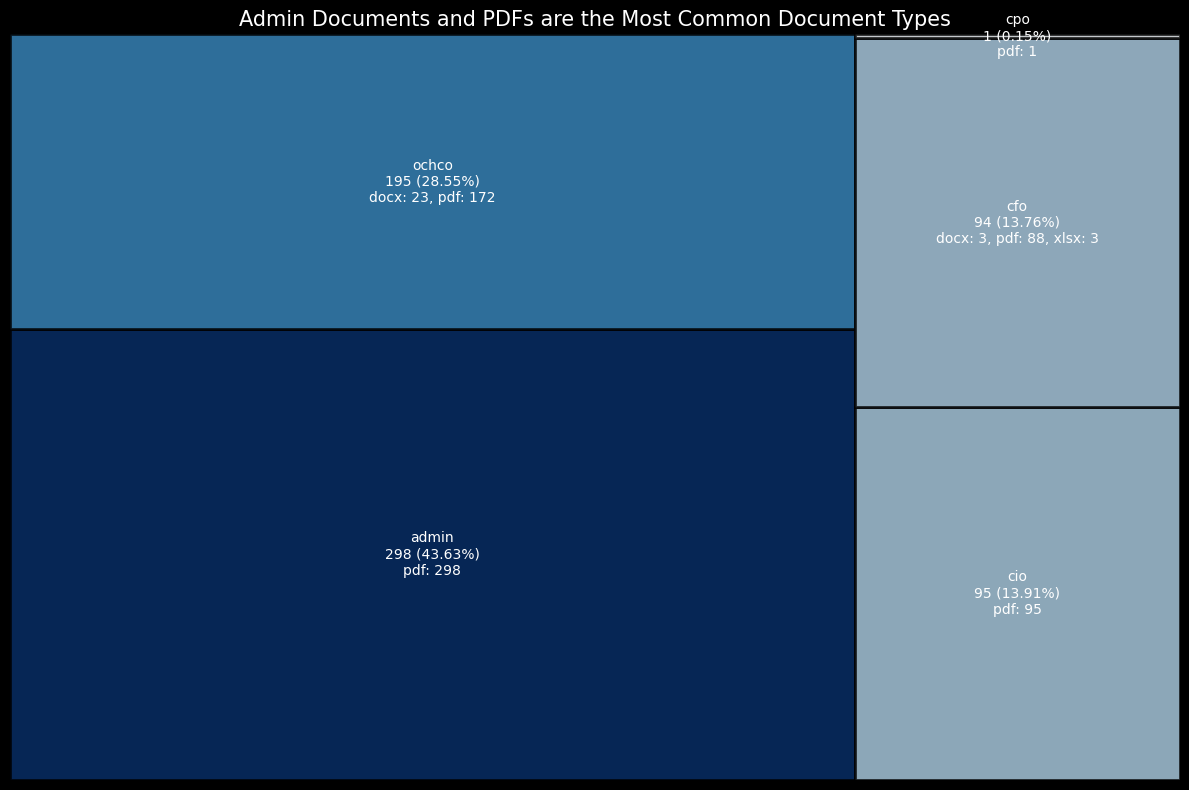

In [262]:
# Exclude rows where pdf_url is blank
filtered_data = full_stacked_scrape[full_stacked_scrape['pdf_url'].notna() & (full_stacked_scrape['pdf_url'] != '')]

# Count the occurrences of each handbook_type
handbook_type_counts = filtered_data['handbook_type'].value_counts().reset_index()
handbook_type_counts.columns = ['handbook_type', 'Count']

# Calculate the distribution of destination_document_type for each handbook_type
handbook_type_details = filtered_data.groupby(['handbook_type', 'destination_document_type']).size().reset_index(name='Count')

# Create a dictionary for handbook_type details
details_dict = {}
for handbook_type in handbook_type_counts['handbook_type']:
    subset = handbook_type_details[handbook_type_details['handbook_type'] == handbook_type]
    details = ', '.join([f"{row['destination_document_type']}: {row['Count']}" for _, row in subset.iterrows()])
    details_dict[handbook_type] = details

# Prepare the data
sizes = handbook_type_counts['Count']  # The count of each type
labels = handbook_type_counts['handbook_type'].tolist()  # The types

# Calculate the percentage of each type for labels
total = sum(sizes)
percentages = [(count / total * 100) for count in sizes]
labels = [f'{label}\n{size} ({percent:.2f}%)\n{details_dict[label]}' for label, size, percent in zip(labels, sizes, percentages)]

# Normalize sizes for color mapping
norm = mcolors.Normalize(vmin=min(sizes), vmax=max(sizes))
colors = [plt.cm.Blues(norm(size)) for size in sizes]

# Set up the plot
plt.figure(figsize=(12, 8))
ax = plt.gca()
ax.set_facecolor('#303030')
plt.style.use('dark_background')

# Plotting the treemap with borders
squarify.plot(sizes=sizes, label=labels, color=colors, alpha=0.8, edgecolor='black', linewidth=2)
plt.title('Admin Documents and PDFs are the Most Common Document Types', color='white', fontsize=15)

# Removing axes for cleaner display
plt.axis('off')
plt.tight_layout()

# Save the plot as a JPG file
plt.savefig('treemap_types.jpg', format='jpg', dpi=300)

# Display the plot
plt.show()

/var/folders/jm/3pr5r3qn5kj1jbb1kk_lcn8c0000gn/T/ipykernel_7679/2418039873.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data.loc[:, 'keyword_count'] = (filtered_data[keyword_columns] > 0).sum(axis=1)


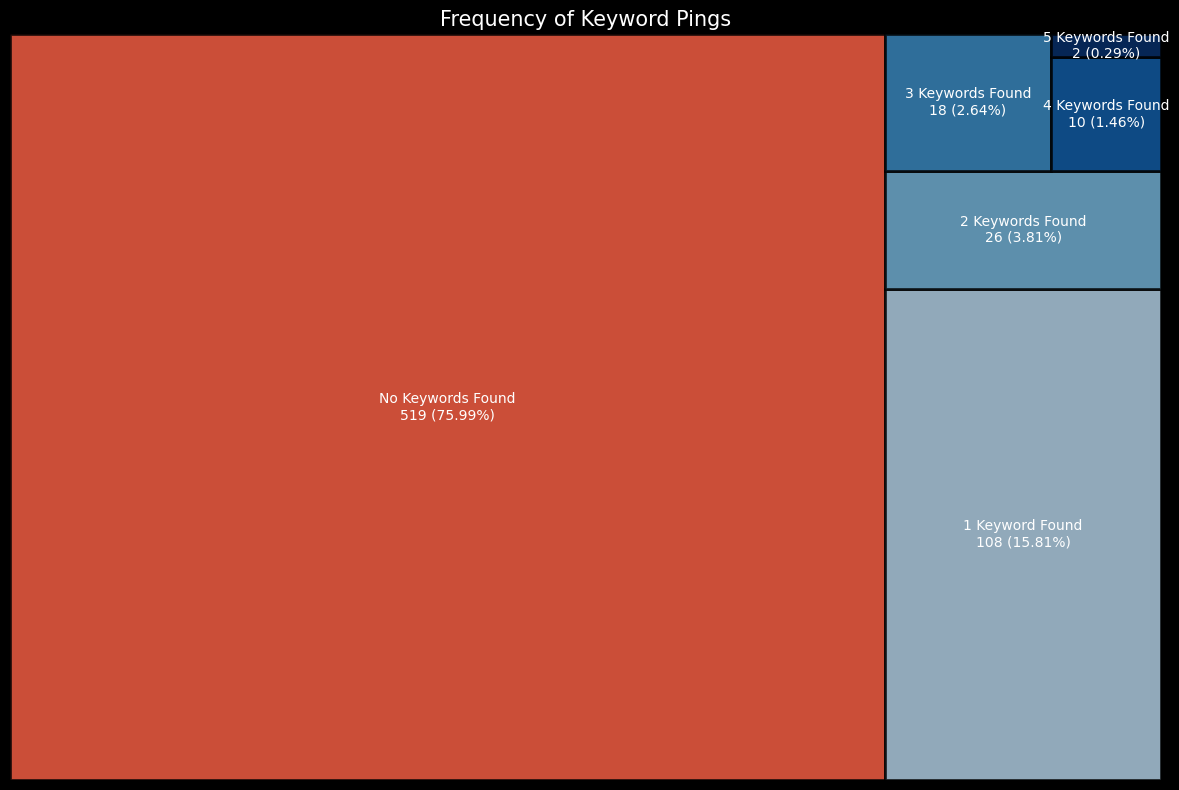

In [263]:
# Exclude rows where pdf_url is blank
filtered_data = full_stacked_scrape[full_stacked_scrape['pdf_url'].notna() & (full_stacked_scrape['pdf_url'] != '')]

# Define the keyword columns
keyword_columns = ['508', 'disab', 'accessib', 'assistive tech', 'rehab', 'ICT']

# Determine the number of keywords found in each row
filtered_data.loc[:, 'keyword_count'] = (filtered_data[keyword_columns] > 0).sum(axis=1)

# Create a dictionary to hold the counts for each category
keyword_categories = {
    'No Keywords Found': (filtered_data['keyword_count'] == 0).sum()
}

# Add categories for 1 keyword, 2 keywords, etc.
for i in range(1, filtered_data['keyword_count'].max() + 1):
    count = (filtered_data['keyword_count'] == i).sum()
    if count > 0:
        keyword_categories[f'{i} Keyword{"s" if i > 1 else ""} Found'] = count

# Prepare the data for the treemap
labels = list(keyword_categories.keys())
sizes = list(keyword_categories.values())

# Calculate the percentage of each type for labels
total = sum(sizes)
percentages = [(count / total * 100) for count in sizes]
labels = [f'{label}\n{size} ({percent:.2f}%)' for label, size, percent in zip(labels, sizes, percentages)]

# Colors for the treemap: orange for 'No Keywords Found' and gradations of blue for the rest
colors = ['#FF6347'] + [plt.cm.Blues(i) for i in np.linspace(0.3, 1, len(labels) - 1)]

# Set up the plot
plt.figure(figsize=(12, 8))
ax = plt.gca()
ax.set_facecolor('#2E2E2E')
plt.style.use('dark_background')

# Plotting the treemap
squarify.plot(sizes=sizes, label=labels, color=colors, alpha=0.8, edgecolor='black', linewidth=2)
plt.title('Frequency of Keyword Pings', color='white', fontsize=15)

# Removing axes for cleaner display
plt.axis('off')
plt.tight_layout()

# Save the plot as a JPG file
plt.savefig('keyword_treemap.jpg', format='jpg', dpi=300)

# Display the plot
plt.show()

In [253]:
# Exclude rows where pdf_url is blank
filtered_data = full_stacked_scrape[full_stacked_scrape['pdf_url'].notna() & (full_stacked_scrape['pdf_url'] != '')]

# Define the keyword to query
keyword = 'disab'

# Filter rows where the keyword 'disab' is greater than 0
keyword_filtered_data = filtered_data[filtered_data[keyword] > 0]

# Group by 'handbook_type' and sum the occurrences of the keyword
keyword_counts_by_type = keyword_filtered_data.groupby('handbook_type')[keyword].sum()

# Display the result
keyword_counts_by_type

handbook_type
admin     98
cfo       28
cio       17
cpo        1
ochco    591
Name: disab, dtype: int64

/var/folders/jm/3pr5r3qn5kj1jbb1kk_lcn8c0000gn/T/ipykernel_7679/4220297529.py:31: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = plt.cm.get_cmap('tab20', len(handbook_types))


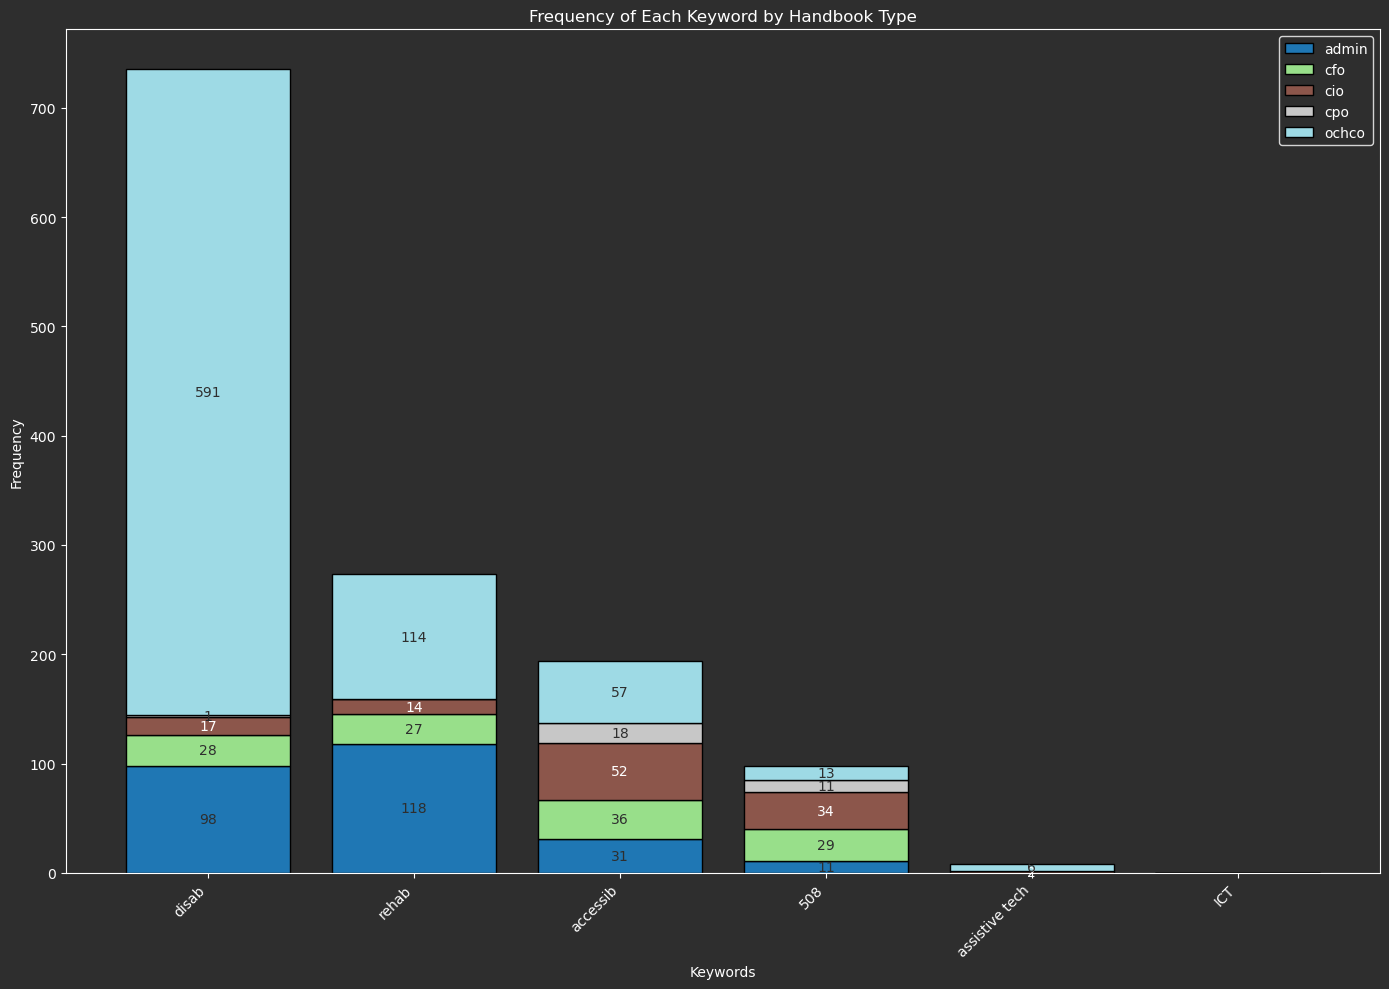

In [264]:
# Exclude rows where pdf_url is blank
filtered_data = full_stacked_scrape[full_stacked_scrape['pdf_url'].notna() & (full_stacked_scrape['pdf_url'] != '')]

# Define the keyword columns
keyword_columns = ['508', 'disab', 'accessib', 'assistive tech', 'rehab', 'ICT']

# Filter rows with at least one keyword ping
rows_with_keywords = filtered_data[(filtered_data[keyword_columns] > 0).any(axis=1)]

# Calculate the total mentions of each keyword
total_keyword_counts = rows_with_keywords[keyword_columns].sum().sort_values(ascending=False)

# Calculate the mentions of each keyword by handbook_type
keyword_counts_by_type = rows_with_keywords.groupby('handbook_type')[keyword_columns].sum()

# Ensure the order of handbook types is consistent with their appearance in the bars
handbook_types = keyword_counts_by_type.index

# Function to determine if a color is light or dark
def is_light_color(color):
    r, g, b, _ = color
    hsv = rgb_to_hsv([r, g, b])
    return hsv[2] > 0.7  # Use the value component of HSV color space

# Create the plot
fig, ax = plt.subplots(figsize=(14, 10), facecolor='#2E2E2E')
ax.set_facecolor('#2E2E2E')
plt.style.use('dark_background')

# Define colors for the bars (using a color map with enough colors for handbook types)
color_map = plt.cm.get_cmap('tab20', len(handbook_types))
colors = [color_map(i) for i in range(len(handbook_types))]

# Create a color dictionary for handbook_types
color_dict = {handbook_type: color for handbook_type, color in zip(handbook_types, colors)}

# Plot the stacked bar graph
bottom = np.zeros(len(total_keyword_counts))
bars = []
for handbook_type in handbook_types:
    counts = keyword_counts_by_type.loc[handbook_type, total_keyword_counts.index]
    bar = ax.bar(total_keyword_counts.index, counts, bottom=bottom, color=color_dict[handbook_type], edgecolor='black', label=handbook_type)
    bars.append(bar)
    bottom += counts

# Add data labels with adaptive colors
for bar in bars:
    for rect in bar:
        width = rect.get_width()
        height = rect.get_height()
        if height > 0:
            color = rect.get_facecolor()
            label_color = '#2E2E2E' if is_light_color(color) else 'white'
            ax.text(rect.get_x() + width / 2, rect.get_y() + height / 2, f'{int(height)}', ha='center', va='center', color=label_color, fontsize=10)

# Add labels and title
ax.set_xlabel('Keywords', color='white')
ax.set_ylabel('Frequency', color='white')
ax.set_title('Frequency of Each Keyword by Handbook Type', color='white')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right', color='white')
ax.tick_params(colors='white')

# Add legend
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), facecolor='#2E2E2E', edgecolor='white', loc='best')

# Save the plot as a JPG file
plt.savefig('keyword_frequency_by_handbook_type.jpg', format='jpg', dpi=300)

# Display the plot
plt.tight_layout()
plt.show()

## Investigating Keyword Flags

Next, we need so subset the main data frame into rows where a keyword was flagged in any of the keyword columns

In [233]:
# Create the raw_keyword_pings subset
raw_keyword_pings = full_stacked_scrape[
    (full_stacked_scrape['508'] > 0) |
    (full_stacked_scrape['disab'] > 0) |
    (full_stacked_scrape['accessib'] > 0) |
    (full_stacked_scrape['assistive tech'] > 0) |
    (full_stacked_scrape['rehab'] > 0) |
    (full_stacked_scrape['ICT'] > 0)
]

# Display the raw_keyword_pings subset
raw_keyword_pings

,handbook_code,handbook_name,handbook_notes,url,handbook_type,pdf_name,pdf_url,508,disab,accessib,assistive tech,rehab,ICT,url_test,searchable,straight_to_pdf,destination_document_type
0,1325.1,HUD Privacy Handbook Rev 1.0,NaN,https://www.hud.gov/sites/dfiles/OCHCO/documen...,admin,HUD Privacy Handbook Rev 1.0,https://www.hud.gov/sites/dfiles/OCHCO/documen...,0,0,2,0,0,0,True,True,True,pdf
1,1400.1,FOIA Proactive Disclosure Policy,NaN,https://www.hud.gov/sites/dfiles/OCHCO/documen...,admin,FOIA Proactive Disclosure Policy,https://www.hud.gov/sites/dfiles/OCHCO/documen...,0,1,0,0,0,0,True,True,True,pdf
2,2300.4,Fleet Management,NaN,https://www.hud.gov/sites/documents/23004ADMH.pdf,admin,Fleet Management,https://www.hud.gov/sites/documents/23004ADMH.pdf,0,1,1,0,0,0,True,True,True,pdf
3,3150.1,HUD Breach Notification Response Plan (HBNRP) ...,NaN,https://www.hud.gov/sites/dfiles/OCHCO/documen...,admin,HUD Breach Notification Response Plan (HBNRP) ...,https://www.hud.gov/sites/dfiles/OCHCO/documen...,5,1,5,0,0,0,True,True,True,pdf
4,3230.2,Physical Security Handbook for HUD Regional an...,NaN,https://www.hud.gov/sites/documents/32302ADMH.pdf,admin,Physical Security Handbook for HUD Regional an...,https://www.hud.gov/sites/documents/32302ADMH.pdf,0,34,4,0,0,0,True,True,True,pdf
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
684,7855.1,PROCEDURES FOR PROVIDING REASONABLE ACCOMMODATION,NaN,https://www.hud.gov/program_offices/administra...,ochco,"APPENDIX 4:HUD Form 11601, Reasonable Accommod...",https://www.hud.gov/sites/dfiles/OCHCO/documen...,0,2,0,0,0,0,True,True,False,pdf
686,7855.1,PROCEDURES FOR PROVIDING REASONABLE ACCOMMODATION,NaN,https://www.hud.gov/program_offices/administra...,ochco,"APPENDIX 5:HUD Form 22006, Computer/Technology...",https://www.hud.gov/sites/dfiles/OCHCO/documen...,1,2,0,4,0,0,True,True,False,pdf
688,7855.1,PROCEDURES FOR PROVIDING REASONABLE ACCOMMODATION,NaN,https://www.hud.gov/program_offices/administra...,ochco,APPENDIX 6:GLOSSARY OF FUNCTIONAL LIMITATIONS,https://www.hud.gov/sites/dfiles/OCHCO/documen...,0,16,0,0,0,0,True,True,False,pdf
690,7855.1,PROCEDURES FOR PROVIDING REASONABLE ACCOMMODATION,NaN,https://www.hud.gov/program_offices/administra...,ochco,APPENDIX 7:RESOURCES,https://www.hud.gov/sites/dfiles/OCHCO/documen...,2,58,8,2,12,0,True,True,False,pdf


In [234]:
# Find duplicates based on 'pdf_url'
duplicates = raw_keyword_pings[raw_keyword_pings.duplicated('pdf_url', keep=False)]

# Display the duplicates
duplicates

,handbook_code,handbook_name,handbook_notes,url,handbook_type,pdf_name,pdf_url,508,disab,accessib,assistive tech,rehab,ICT,url_test,searchable,straight_to_pdf,destination_document_type


From here, we need to investigate the context of these keyword flags. Each "ping" will need to become its own row. The value of that keyword column will then have to be the sentence where the word was included.

Now, just to be aware - this is currently structured to pull an individual row even if the keyword is found multiple times in the same sentence. But like before, we can remove duplicates closer to the end

This code tries for the whole 164 rows

In [235]:
# Function to extract sentences from a PDF given a keyword
def extract_sentences_from_pdf(pdf_url, keyword):
    try:
        response = requests.get(pdf_url)
        if response.status_code == 200:
            with BytesIO(response.content) as file:
                reader = PyPDF2.PdfReader(file)
                num_pages = len(reader.pages)
                sentences = []

                for page_num in range(num_pages):
                    page_text = reader.pages[page_num].extract_text()
                    if keyword.lower() in page_text.lower():
                        context_sentences = extract_sentences(page_text, keyword)
                        sentences.extend(context_sentences)
                        
                return sentences
        else:
            print(f"Failed to retrieve {pdf_url}: Status code {response.status_code}")
            return []
    except Exception as e:
        print(f"Error reading {pdf_url}: {e}")
        return []

# Function to extract sentences containing the keyword from text
def extract_sentences(text, keyword):
    pattern = re.compile(r'([^.]*?{}[^.]*\.)'.format(re.escape(keyword)), re.IGNORECASE)
    all_sentences = pattern.findall(text)
    keyword_sentences = []
    
    for sentence in all_sentences:
        occurrences = [m.start() for m in re.finditer(re.escape(keyword), sentence, re.IGNORECASE)]
        for start in occurrences:
            keyword_sentences.append((sentence, start))
    
    return keyword_sentences

# Assuming raw_keyword_pings is already loaded in memory
test_rows = raw_keyword_pings  # Process all rows

keywords = ['508', 'disab', 'accessib', 'assistive tech', 'rehab', 'ICT']
keyword_columns = ['508', 'disab', 'accessib', 'assistive tech', 'rehab', 'ICT']

# Initialize list to hold rows for the new DataFrame
new_rows = []

# Split the DataFrame into batches of 10 rows each
batch_size = 10
batches = [test_rows[i:i + batch_size] for i in range(0, len(test_rows), batch_size)]

# Process each batch
for batch in tqdm(batches, desc="Processing batches"):
    for _, row in batch.iterrows():
        for keyword, column in zip(keywords, keyword_columns):
            count = row[column]
            if count > 0 and pd.notna(row['pdf_url']):
                sentences = extract_sentences_from_pdf(row['pdf_url'], keyword)
                for sentence, position in sentences:
                    new_row = {
                        'handbook_code': row['handbook_code'],
                        'handbook_name': row['handbook_name'],
                        'handbook_notes': row['handbook_notes'],
                        'url': row['url'],
                        'handbook_type': row['handbook_type'],
                        'pdf_name': row['pdf_name'],
                        'pdf_url': row['pdf_url'],
                        'keyword': keyword,
                        'context': sentence.strip(),
                        'position': position
                    }
                    new_rows.append(new_row)

# Create a new DataFrame from the new rows
keyword_context_df = pd.DataFrame(new_rows)

# Display the new DataFrame
keyword_context_df

Processing batches: 100%|██████████| 17/17 [10:25<00:00, 36.81s/it]


,handbook_code,handbook_name,handbook_notes,url,handbook_type,pdf_name,pdf_url,keyword,context,position
0,1325.1,HUD Privacy Handbook Rev 1.0,NaN,https://www.hud.gov/sites/dfiles/OCHCO/documen...,admin,HUD Privacy Handbook Rev 1.0,https://www.hud.gov/sites/dfiles/OCHCO/documen...,accessib,Transparency: \nHUD should be transparent abo...,135
1,1325.1,HUD Privacy Handbook Rev 1.0,NaN,https://www.hud.gov/sites/dfiles/OCHCO/documen...,admin,HUD Privacy Handbook Rev 1.0,https://www.hud.gov/sites/dfiles/OCHCO/documen...,accessib,"For example, a change in the access controls t...",80
2,1400.1,FOIA Proactive Disclosure Policy,NaN,https://www.hud.gov/sites/dfiles/OCHCO/documen...,admin,FOIA Proactive Disclosure Policy,https://www.hud.gov/sites/dfiles/OCHCO/documen...,disab,(9) Housing for individuals with disabilities.,35
3,2300.4,Fleet Management,NaN,https://www.hud.gov/sites/documents/23004ADMH.pdf,admin,Fleet Management,https://www.hud.gov/sites/documents/23004ADMH.pdf,disab,Disabled Vehicle .,1
4,2300.4,Fleet Management,NaN,https://www.hud.gov/sites/documents/23004ADMH.pdf,admin,Fleet Management,https://www.hud.gov/sites/documents/23004ADMH.pdf,accessib,Field Work - Official work performed by an em...,323
...,...,...,...,...,...,...,...,...,...,...
1248,7855.1,PROCEDURES FOR PROVIDING REASONABLE ACCOMMODATION,NaN,https://www.hud.gov/program_offices/administra...,ochco,APPENDIX 8:Executive Order 13164,https://www.hud.gov/sites/dfiles/OCHCO/documen...,disab,"146 / Friday, July 28, 2000 / Presidential Doc...",395
1249,7855.1,PROCEDURES FOR PROVIDING REASONABLE ACCOMMODATION,NaN,https://www.hud.gov/program_offices/administra...,ochco,APPENDIX 8:Executive Order 13164,https://www.hud.gov/sites/dfiles/OCHCO/documen...,disab,Agencies must also inform \nindividuals with d...,45
1250,7855.1,PROCEDURES FOR PROVIDING REASONABLE ACCOMMODATION,NaN,https://www.hud.gov/program_offices/administra...,ochco,APPENDIX 8:Executive Order 13164,https://www.hud.gov/sites/dfiles/OCHCO/documen...,disab,(a) Nothing in this order limits the rights th...,68
1251,7855.1,PROCEDURES FOR PROVIDING REASONABLE ACCOMMODATION,NaN,https://www.hud.gov/program_offices/administra...,ochco,APPENDIX 8:Executive Order 13164,https://www.hud.gov/sites/dfiles/OCHCO/documen...,rehab,"146 / Friday, July 28, 2000 / Presidential Doc...",366


Now, for any rows that are returned, we can create two columns that look at the expect and actual pings that were successfully scrape for each url and keyword combination

In [236]:
# Step 1: Add expected_pings to keyword_context_df
def get_expected_pings(row):
    try:
        return raw_keyword_pings.loc[raw_keyword_pings['pdf_url'] == row['pdf_url'], row['keyword']].values[0]
    except IndexError:
        return 0

# Create a copy of keyword_context_df to avoid overwriting it
UPDATED_keyword_context_df = keyword_context_df.copy()

# Apply the function to add expected_pings
UPDATED_keyword_context_df['expected_pings'] = UPDATED_keyword_context_df.apply(get_expected_pings, axis=1)

# Step 2: Compute actual_pings for keyword_context_df
actual_pings_counts = UPDATED_keyword_context_df.groupby(['pdf_url', 'keyword']).size().reset_index(name='actual_pings')

# Merge actual_pings with UPDATED_keyword_context_df
UPDATED_keyword_context_df = UPDATED_keyword_context_df.merge(actual_pings_counts, on=['pdf_url', 'keyword'], how='left')

# Save to a new CSV file if needed
UPDATED_keyword_context_df.to_csv('UPDATED_keyword_context_df.csv', index=False)

# Display the updated DataFrame
UPDATED_keyword_context_df

,handbook_code,handbook_name,handbook_notes,url,handbook_type,pdf_name,pdf_url,keyword,context,position,expected_pings,actual_pings
0,1325.1,HUD Privacy Handbook Rev 1.0,NaN,https://www.hud.gov/sites/dfiles/OCHCO/documen...,admin,HUD Privacy Handbook Rev 1.0,https://www.hud.gov/sites/dfiles/OCHCO/documen...,accessib,Transparency: \nHUD should be transparent abo...,135,2,2
1,1325.1,HUD Privacy Handbook Rev 1.0,NaN,https://www.hud.gov/sites/dfiles/OCHCO/documen...,admin,HUD Privacy Handbook Rev 1.0,https://www.hud.gov/sites/dfiles/OCHCO/documen...,accessib,"For example, a change in the access controls t...",80,2,2
2,1400.1,FOIA Proactive Disclosure Policy,NaN,https://www.hud.gov/sites/dfiles/OCHCO/documen...,admin,FOIA Proactive Disclosure Policy,https://www.hud.gov/sites/dfiles/OCHCO/documen...,disab,(9) Housing for individuals with disabilities.,35,1,1
3,2300.4,Fleet Management,NaN,https://www.hud.gov/sites/documents/23004ADMH.pdf,admin,Fleet Management,https://www.hud.gov/sites/documents/23004ADMH.pdf,disab,Disabled Vehicle .,1,1,1
4,2300.4,Fleet Management,NaN,https://www.hud.gov/sites/documents/23004ADMH.pdf,admin,Fleet Management,https://www.hud.gov/sites/documents/23004ADMH.pdf,accessib,Field Work - Official work performed by an em...,323,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
1248,7855.1,PROCEDURES FOR PROVIDING REASONABLE ACCOMMODATION,NaN,https://www.hud.gov/program_offices/administra...,ochco,APPENDIX 8:Executive Order 13164,https://www.hud.gov/sites/dfiles/OCHCO/documen...,disab,"146 / Friday, July 28, 2000 / Presidential Doc...",395,13,10
1249,7855.1,PROCEDURES FOR PROVIDING REASONABLE ACCOMMODATION,NaN,https://www.hud.gov/program_offices/administra...,ochco,APPENDIX 8:Executive Order 13164,https://www.hud.gov/sites/dfiles/OCHCO/documen...,disab,Agencies must also inform \nindividuals with d...,45,13,10
1250,7855.1,PROCEDURES FOR PROVIDING REASONABLE ACCOMMODATION,NaN,https://www.hud.gov/program_offices/administra...,ochco,APPENDIX 8:Executive Order 13164,https://www.hud.gov/sites/dfiles/OCHCO/documen...,disab,(a) Nothing in this order limits the rights th...,68,13,10
1251,7855.1,PROCEDURES FOR PROVIDING REASONABLE ACCOMMODATION,NaN,https://www.hud.gov/program_offices/administra...,ochco,APPENDIX 8:Executive Order 13164,https://www.hud.gov/sites/dfiles/OCHCO/documen...,rehab,"146 / Friday, July 28, 2000 / Presidential Doc...",366,2,2


Now all we need to do is transpose any values from pdf_urls that may be missing from the original raw data set into this updated one. Then they can be checked manually

In [237]:
# Function to find missing pdf_urls and add them to UPDATED_keyword_context_df
def add_missing_pdf_urls(raw_df, updated_df, keyword_columns):
    # Find missing pdf_urls
    missing_pdf_urls = set(raw_df['pdf_url']) - set(updated_df['pdf_url'])
    
    # Initialize a list to hold the new rows
    new_rows = []

    # Iterate over missing pdf_urls
    for pdf_url in missing_pdf_urls:
        # Get the corresponding row in raw_df
        row = raw_df[raw_df['pdf_url'] == pdf_url]
        if row.empty:
            continue
        
        for keyword in keyword_columns:
            expected_count = row[keyword].values[0]
            if expected_count > 0:
                new_row = {
                    'handbook_code': row['handbook_code'].values[0],
                    'handbook_name': row['handbook_name'].values[0],
                    'handbook_notes': row['handbook_notes'].values[0],
                    'url': row['url'].values[0],
                    'handbook_type': row['handbook_type'].values[0],
                    'pdf_name': row['pdf_name'].values[0],
                    'pdf_url': row['pdf_url'].values[0],
                    'keyword': keyword,
                    'context': '',
                    'position': None,
                    'expected_pings': expected_count,
                    'actual_pings': 0
                }
                new_rows.append(new_row)
    
    # Create a DataFrame from the new rows
    new_rows_df = pd.DataFrame(new_rows)

    # Append the new rows to UPDATED_keyword_context_df
    updated_df = pd.concat([updated_df, new_rows_df], ignore_index=True)
    
    return updated_df

# Specify the keyword columns
keyword_columns = ['508', 'disab', 'accessib', 'assistive tech', 'rehab', 'ICT']

# Call the function to add missing pdf_urls to UPDATED_keyword_context_df
UPDATED_keyword_context_df_with_missing = add_missing_pdf_urls(raw_keyword_pings, UPDATED_keyword_context_df, keyword_columns)

# Save to a new CSV file if needed
UPDATED_keyword_context_df_with_missing.to_csv('UPDATED_keyword_context_df_with_missing.csv', index=False)

# Display the updated DataFrame with the missing pdf_urls added
UPDATED_keyword_context_df_with_missing

,handbook_code,handbook_name,handbook_notes,url,handbook_type,pdf_name,pdf_url,keyword,context,position,expected_pings,actual_pings
0,1325.1,HUD Privacy Handbook Rev 1.0,NaN,https://www.hud.gov/sites/dfiles/OCHCO/documen...,admin,HUD Privacy Handbook Rev 1.0,https://www.hud.gov/sites/dfiles/OCHCO/documen...,accessib,Transparency: \nHUD should be transparent abo...,135,2,2
1,1325.1,HUD Privacy Handbook Rev 1.0,NaN,https://www.hud.gov/sites/dfiles/OCHCO/documen...,admin,HUD Privacy Handbook Rev 1.0,https://www.hud.gov/sites/dfiles/OCHCO/documen...,accessib,"For example, a change in the access controls t...",80,2,2
2,1400.1,FOIA Proactive Disclosure Policy,NaN,https://www.hud.gov/sites/dfiles/OCHCO/documen...,admin,FOIA Proactive Disclosure Policy,https://www.hud.gov/sites/dfiles/OCHCO/documen...,disab,(9) Housing for individuals with disabilities.,35,1,1
3,2300.4,Fleet Management,NaN,https://www.hud.gov/sites/documents/23004ADMH.pdf,admin,Fleet Management,https://www.hud.gov/sites/documents/23004ADMH.pdf,disab,Disabled Vehicle .,1,1,1
4,2300.4,Fleet Management,NaN,https://www.hud.gov/sites/documents/23004ADMH.pdf,admin,Fleet Management,https://www.hud.gov/sites/documents/23004ADMH.pdf,accessib,Field Work - Official work performed by an em...,323,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
1255,2255.3,Distribution of HUD Printed Materials,NaN,https://www.hud.gov/program_offices/administra...,admin,APPENDIX 2: DEPARTMENTAL MAILING LISTS,https://www.hud.gov/sites/documents/22553x2ADM...,rehab,,None,5,0
1256,1980.1,Accounting Policies,NaN,https://www.hud.gov/program_offices/administra...,cfo,CHAPTER 3: GRANT ACCRUAL POLICY. (See the Depa...,https://www.hud.gov/sites/documents/cfo-14-002...,disab,,None,1,0
1257,1830.6,User Fees,NaN,https://www.hud.gov/program_offices/administra...,cfo,"APPENDIX A: OMB Circular No. A-25, User Charges",https://www.hud.gov/sites/documents/18306xaCFO...,accessib,,None,1,0
1258,1911.1,Handling and Protecting Cash and Other Negotia...,NaN,https://www.hud.gov/program_offices/administra...,cfo,CHAPTER 1: Handling and Protecting Cash and Ne...,https://www.hud.gov/sites/documents/19111C1CFO...,disab,,None,1,0
